<a href="https://colab.research.google.com/github/nenadgolubovic/MSTAGCN_USA_Airports/blob/main/MSTAGCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PRIMENA MSTAGCN ALGORITMA ZA PREDVIDJANJE KASNJENJA LETOVA U DOLASKU NA PRIMERU AERODROMA NA TERITORIJI SJEDINJENIH AMERICKIH DRZAVA**



# **UVOD**

Odredjivanje prosecnog kasnjenja(zagusenosti) aerodroma odredjuje se algoritmima Graphical Neural Network, i to Relational Graphical Neural Network (R-GCN). Primenom Reccurent Neural Network (RNN) i preko Adaptive Graphical Neural Network koji je napravljen od 2 modela Spatial GCN i Temporal, odnosno prostorne konvolucije i vremenske konvolucije respektivno.

Model razvijen u ovom radu je bazinran na radu:

Kaiquan Cai, Yue Li, Yiping Fang, Yanbo Zhu. A Deep Learning Approach for Flight Delay Prediction
through Time-Evolving Graphs. IEEE Transactions on Intelligent Transportation Systems, inPress,
pp.1-11. ff10.1109/TITS.2021.3103502ff. ffhal-03428046f

Dostupan na sajtu:
https://hal.science/hal-03428046v1/file/Final%20Version-A%20Deep%20Learning%20Approach%20for%20Flight%20Delay%20Prediction%20through%20Time-Evolving%20Graphs.pdf

# **Ucitavanje podataka i obrada**

Podaci su preuzeti sa sajta "https://www.bts.gov/"

Podaci su prethodno obradjeni u pajton skripti gde su izdvojeni letovi za godinu dana za 35 najzagusenijih aerodroma, odnosno aerodroma koji imaju medjusobno najvise konekcija
U daljem koraku ucitani su podaci sa drajva, lose linije su izbacene iz tabele i uzeti su letovi sa manjim kasnjenjem od 180,  razlog za to je izbacivanje ekstremnig vrednosti kasnjeja jer svaki let nakon 180 minuta kasnjenja se otkazuje pa se u tabeli upisuje stvarna vrednost kasnjenja. Odnosno ako se let otkaze za 3 dana onda ce kasnjenje da bude 24 * 60 *3 = 4320

In [93]:
import pandas as pd
csv_path = '/content/drive/MyDrive/Filtered_Data_20percent_12to20_6m_10.csv'
df = pd.read_csv(csv_path, on_bad_lines='skip')
df = df[df["ARR_DELAY"] < 180].copy()

/tmp/ipython-input-93-1706268640.py:3: DtypeWarning: Columns (11,13,79,86,87,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, on_bad_lines='skip')


Sortiranje aerodroma iz podataka,
Sortiraju se svi podaci u jedan niz kako bi se izvukla lista dolazih i odlaznih aerodroma i izdvajaju se samo jedinstvene vrednosti, onda se pravi mapa indeksa za aerodrome i definise ukupan broj aerodroma

In [94]:
airports = sorted(set(df[['DEST', 'ORIGIN']].values.ravel())) # sortiram sve podatke iz dest i origin i formiram u jedan niz gde izvlacim jedinstvene vrednosti kako se ne bi duplicirali podaci
airports.sort() #sortiram
airport_to_idx = {airport: i for i, airport in enumerate(airports)} #formiram mapu indexa za sve aerodrome
n = len(airports)  # broj čvorova u grafu

Formatiranje kolona, CRS_ARR_TIME i kolone FL_DATE i formiranje kolone TIMESTAMP

In [95]:
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'], format='%m/%d/%Y %I:%M:%S %p') # prebacivanje u datetime
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].astype(str).str.zfill(4)  # popunjavanje nulama sa leve strane kako bi se string na primer od 900 pretvorio u 0900
df['ARR_HOUR'] = df['CRS_ARR_TIME'].str[:2].astype(int) # prva dva su uzeti kao sati i ubaceni su u kolonu ARR_JOUR
df['TIMESTAMP'] = df['FL_DATE'] + pd.to_timedelta(df['ARR_HOUR'], unit='h') # formiranje kolone Timestamp koja predstavlja datum io vreme svakog leta, odnosno svakog

Proracunavanje kasnjenja po standardima avijacije prosecno kasnjenje

---
Kasnjenje predstavlja kolicnik zbira ukupnog kasnjenja i broja otkazanih letova pomnozenog sa 180 (nakon 180 minuta se otkazuje let)  sa ukupnim brojem letova

In [96]:
#Funkcija za racunanje kasnjenja po Eurocontrolu
def calculate_delay(df):
  total_delay = df["ARR_DELAY"].sum()
  num_of_cancalation = df["CANCELLED"].sum()
  num_of_scheduled_flights = df["ARR_DELAY"].count()
  return (total_delay + 180*num_of_cancalation)/num_of_scheduled_flights

Izdvajanje odlika koje su butne za formiranje grafova

Konkretno kod nas u modelu je jedino bitno prosecno kasnjenje leta, da li je let otkazan i izmedju kojih aerodroma se let oobavljao kako bi se izracunala vrednost prosecnog kasnjenja po aerodromu.

In [97]:
df = df[["TIMESTAMP", "ORIGIN", "DEST", "CANCELLED", "ARR_DELAY"]]
df = df.dropna() #skidanje nun vrednosti
df

,TIMESTAMP,ORIGIN,DEST,CANCELLED,ARR_DELAY
0,2023-10-01 08:00:00,JFK,LAX,0.0,-27.0
1,2023-10-01 05:00:00,LAX,JFK,0.0,-20.0
2,2023-10-01 12:00:00,DEN,MIA,0.0,-17.0
3,2023-10-01 12:00:00,BOS,CLT,0.0,-36.0
4,2023-10-01 21:00:00,MIA,ATL,0.0,-4.0
...,...,...,...,...,...
3001706,2023-09-30 08:00:00,BNA,AUS,0.0,-18.0
3001707,2023-09-30 18:00:00,MDW,TPA,0.0,11.0
3001708,2023-09-30 08:00:00,MSP,DEN,0.0,-13.0
3001709,2023-09-30 16:00:00,MCO,DCA,0.0,-10.0


**Formiranje funkcija za izracunavanje matrica susedstva**

Obzirom da mi je matrica susedstva jedan od ulaznih parametara, potrbno je da za svaki snapshot graf napravim ulazne matrice susedstva.


1.   Matricu susedstva dolaznih letova
2.   Matricu susedstva odlaznih letova
3.   Matricu susedstva svih letova



In [98]:
import numpy as np
def adjacency_matrix_for_airports_in(df, airports, airport_to_idx): #dataframe, svi aerodromi i mapa indexa aerodroma
    n = len(airports) # broj aerodroma
    W_in = np.zeros((n, n), dtype=int) # formiranje dummy matrice sa nulama koja je velicine broj aerodroma X broj aerodroma

    for _, row in df.iterrows(): # za svaki red
        origin = row["ORIGIN"] #inicijalizuju se origin i dest
        dest = row["DEST"]
        if origin in airport_to_idx and dest in airport_to_idx: # ukoliko se origin i dest nalaze u mapi aerodroma
            i = airport_to_idx[origin]  #i predstavlja aerodrome poletanja
            j = airport_to_idx[dest]  # j predstavlja aerodrome sletanja
            W_in[i, j] = 1  # postavi vrednost na 1
    return W_in

def adjacency_matrix_for_airports_out(df, airports, airport_to_idx):
    n = len(airports)
    W_out = np.zeros((n, n), dtype=int)

    for _, row in df.iterrows():
        origin = row["ORIGIN"]
        dest = row["DEST"]
        if origin in airport_to_idx and dest in airport_to_idx:
            i = airport_to_idx[dest]
            j = airport_to_idx[origin]
            W_out[i, j] = 1  # binarna veza

    return W_out

def adjacency_matrix_for_airports_bidirectional(df, airports, airport_to_idx):
    n = len(airports)
    A = np.zeros((n, n), dtype=int)

    for _, row in df.iterrows():
        origin = row["ORIGIN"]
        dest = row["DEST"]
        if origin in airport_to_idx and dest in airport_to_idx:
            i = airport_to_idx[origin]
            j = airport_to_idx[dest]
            A[i, j] = 1
            A[j, i] = 1  # dodaj i obrnutu vezu

    return A


Grupisanje svih podataka po timestampu i po dolaznom aerodromu obzirom da se radi o operacijama sletanja gde se pravi AVG_DELAY i primenjuje se funkcija odredjivanja prosecnog kasnjenja na sve vrednosti.

In [99]:
df_out = (df.groupby(["TIMESTAMP", "DEST"], as_index=False).apply(lambda g: pd.Series({"AVG_DELAY": calculate_delay(g)}), include_groups=False))

Prikazivanje matrice df out koja predstavlja po odredjenom vremenskom koraku za aerodrome dolaska prosecna kasnjenja

In [100]:
df_out

,TIMESTAMP,DEST,AVG_DELAY
0,2023-02-01 00:00:00,ATL,10.750000
1,2023-02-01 00:00:00,BNA,-9.333333
2,2023-02-01 00:00:00,BOS,1.800000
3,2023-02-01 00:00:00,BWI,5.000000
4,2023-02-01 00:00:00,DEN,4.400000
...,...,...,...
253350,2024-01-31 23:00:00,SEA,-35.200000
253351,2024-01-31 23:00:00,SFO,-20.916667
253352,2024-01-31 23:00:00,SLC,-25.571429
253353,2024-01-31 23:00:00,STL,-13.833333


Kako bi obezbedili da su timestampovi sortirani kao i u airport_idx potrebno je odraditi sledece

In [101]:
df_out["DEST_ORDER"] = df_out["DEST"].map(airport_to_idx)

In [102]:
pivot = (df_out.pivot_table(index="TIMESTAMP", columns="DEST_ORDER", values="AVG_DELAY",  aggfunc="first")) # funkcija koja ce da mi uzima samo jedinsvene kombinacije tiimestamp+dest order

In [103]:
pivot.columns = [airports[idx] for idx in pivot.columns] #pretvara kolone pivota u nazive umesto u indexe

In [104]:
df_sorted = (pivot.reset_index().melt(id_vars="TIMESTAMP", var_name="DEST", value_name="AVG_DELAY")
.sort_values(["TIMESTAMP", "DEST"],
                 key=lambda col: (col if col.name != "DEST"
                                   else col.map(airport_to_idx)))
    .reset_index(drop=True)
) # kod prosiruje tabeliu tako da se za svaki timestamp pojave svi dest aeroromi

Sortiran dataframe po vremenskom koraku za svaki aerfodrom prosecna kasnjenja

In [105]:
df_sorted

,TIMESTAMP,DEST,AVG_DELAY
0,2023-02-01 00:00:00,ATL,10.750000
1,2023-02-01 00:00:00,AUS,NaN
2,2023-02-01 00:00:00,BNA,-9.333333
3,2023-02-01 00:00:00,BOS,1.800000
4,2023-02-01 00:00:00,BWI,5.000000
...,...,...,...
290005,2024-01-31 23:00:00,SEA,-35.200000
290006,2024-01-31 23:00:00,SFO,-20.916667
290007,2024-01-31 23:00:00,SLC,-25.571429
290008,2024-01-31 23:00:00,STL,-13.833333


Da bi napravili ulazne podatke, odnosno sekvence podataka, potrebno je napravimo dataframe gde cemo predstaviti vremenski korak i X_t odnosno prosecna kasnjenja za sve aerodrome

In [106]:
import torch
def grupu_u_tensor(grupa):
    v = [0.1] * n
    for _, row in grupa.iterrows():
        v[airport_to_idx[row["DEST"]]] = row["AVG_DELAY"]
    t = torch.tensor(v, dtype=torch.float32)
    t[torch.isnan(t)] = 0.0001
    return t
df_with_tensors = (
    df_sorted
    .groupby("TIMESTAMP", group_keys=False)
    .apply(lambda g: pd.Series({"X_t": grupu_u_tensor(g)}), include_groups=False)
    .reset_index()
)

In [107]:
df_with_tensors

,TIMESTAMP,X_t
0,2023-02-01 00:00:00,"[tensor(10.7500), tensor(1.0000e-04), tensor(-..."
1,2023-02-01 01:00:00,"[tensor(1.0000e-04), tensor(1.0000e-04), tenso..."
2,2023-02-01 04:00:00,"[tensor(1.0000e-04), tensor(1.0000e-04), tenso..."
3,2023-02-01 05:00:00,"[tensor(-5.8333), tensor(43.), tensor(1.0000e-..."
4,2023-02-01 06:00:00,"[tensor(-7.2857), tensor(1.0000e-04), tensor(-..."
...,...,...
8281,2024-01-31 19:00:00,"[tensor(-9.1364), tensor(-11.3333), tensor(-5...."
8282,2024-01-31 20:00:00,"[tensor(-8.2692), tensor(-11.), tensor(-3.4667..."
8283,2024-01-31 21:00:00,"[tensor(-3.0690), tensor(-16.1667), tensor(-6...."
8284,2024-01-31 22:00:00,"[tensor(-19.9091), tensor(-25.8000), tensor(-1..."


Obzirom da je mreza jako gusta u periodima od 12 do 20h, uzimamo samo vrednosti iz tog vremenskog perioda, kako bi pokusali da izbegnemo periode bez letova i obezbedili robusnost modela.

In [108]:
df_with_tensors = df_with_tensors[
    (df_with_tensors['TIMESTAMP'].dt.hour >= 12) &
    (df_with_tensors['TIMESTAMP'].dt.hour <= 20)
]
df_with_tensors

,TIMESTAMP,X_t
10,2023-02-01 12:00:00,"[tensor(-7.5417), tensor(17.7500), tensor(21.1..."
11,2023-02-01 13:00:00,"[tensor(9.7200), tensor(19.1250), tensor(3.), ..."
12,2023-02-01 14:00:00,"[tensor(-4.7500), tensor(35.), tensor(5.), ten..."
13,2023-02-01 15:00:00,"[tensor(-2.7241), tensor(0.7500), tensor(11.40..."
14,2023-02-01 16:00:00,"[tensor(-9.6875), tensor(15.6667), tensor(7.70..."
...,...,...
8278,2024-01-31 16:00:00,"[tensor(-15.3043), tensor(-3.9000), tensor(-18..."
8279,2024-01-31 17:00:00,"[tensor(-7.0909), tensor(3.), tensor(-7.9231),..."
8280,2024-01-31 18:00:00,"[tensor(-17.1111), tensor(-17.8000), tensor(-4..."
8281,2024-01-31 19:00:00,"[tensor(-9.1364), tensor(-11.3333), tensor(-5...."


df_with_tensor sad predstavlja tabelu sa X_t, odnosno kasnjenja svih aerodroma u odredjenom timestampu, u daljem radu to bi trebali da mi budu izlazni podaci iz modela. Odnosno target predvidjanja

Treba napraviti funkciju koja ce da extraktuje segmente na osnovu unetih podataka, gde ce ulazni parametri da budu pocetni i krajnji index segmenta, lista pytorch tensora, i indeks koji se koristi kao default ako trazeni ne postoji

In [109]:

def extract_segment(i_start, i_end, X_list, default_tensor):
    # i_start i i_end su indeksi u df_with_tensors
    # ako je indeks van opsega, vrati default tensor (nule)
    n = i_end - i_start + 1 #izracunavanje duzine
    if i_start < 0 or i_end >= len(X_list):   #ukoliko je start manji od 0 ili ukoliko end prevazilazi duzinu liste onda
        return default_tensor.unsqueeze(0).repeat(n, 1)
    else:
        segment = torch.stack(X_list[i_start:i_end+1])  # shape (n, features) #ukoliko ne onda se varaca stack iz liste od pocetnog do kranjeg indek
        return segment


Formiranje serije

In [110]:
N = 21

X_list = df_with_tensors["X_t"].tolist()  # lista tensor vrednosti
timestamp_to_idx = {ts: i for i, ts in enumerate(df_with_tensors["TIMESTAMP"])}
time_series_list = []

for ts in df_with_tensors["TIMESTAMP"]:
    idx = timestamp_to_idx[ts]

    Pr = extract_segment(idx - N, idx - 1, X_list, torch.zeros_like(X_list[0]))
    Pd = extract_segment(idx - 24 - N, idx - 24 - 1, X_list, torch.zeros_like(X_list[0]))
    Pw = extract_segment(idx - 7*24 - N, idx - 7*24 - 1, X_list, torch.zeros_like(X_list[0]))

    combined = torch.cat([Pr, Pd, Pw], dim=0)  # shape (3, N, features)
    time_series_list.append(combined)

# Napravi novu kolonu u df
df_with_tensors["time_series"] = time_series_list

/tmp/ipython-input-110-2332935987.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_tensors["time_series"] = time_series_list


In [111]:
df_with_tensors

,TIMESTAMP,X_t,time_series
10,2023-02-01 12:00:00,"[tensor(-7.5417), tensor(17.7500), tensor(21.1...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
11,2023-02-01 13:00:00,"[tensor(9.7200), tensor(19.1250), tensor(3.), ...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
12,2023-02-01 14:00:00,"[tensor(-4.7500), tensor(35.), tensor(5.), ten...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
13,2023-02-01 15:00:00,"[tensor(-2.7241), tensor(0.7500), tensor(11.40...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
14,2023-02-01 16:00:00,"[tensor(-9.6875), tensor(15.6667), tensor(7.70...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
...,...,...,...
8278,2024-01-31 16:00:00,"[tensor(-15.3043), tensor(-3.9000), tensor(-18...","[[tensor(-13.4348), tensor(-8.4286), tensor(-1..."
8279,2024-01-31 17:00:00,"[tensor(-7.0909), tensor(3.), tensor(-7.9231),...","[[tensor(-16.6087), tensor(-15.6923), tensor(-..."
8280,2024-01-31 18:00:00,"[tensor(-17.1111), tensor(-17.8000), tensor(-4...","[[tensor(-3.9167), tensor(1.2500), tensor(0.15..."
8281,2024-01-31 19:00:00,"[tensor(-9.1364), tensor(-11.3333), tensor(-5....","[[tensor(-12.), tensor(3.), tensor(-9.9091), t..."


Sad je potrebno napraviti df sa svim matricama susedstva za svaki timestamps

In [112]:
df_sorted = df.sort_values('TIMESTAMP') # sortiramo podatke po timestampu

timestamps = [] #lista koja ce predstavljati timestamp u df
W_in_list = [] # Matrica susedstva za dolazne
W_out_list = [] # Matrica susetstva za odlazne letove
A_list = [] # matrica susedstva
grouped = df_sorted.groupby('TIMESTAMP') # grupisanje po timestampu

for ts, group_df in grouped:  #za svaki timestamp u grupi podataka
    timestamps.append(ts) # timestampovi, dodaj ts
    W_in = adjacency_matrix_for_airports_in(group_df, airports, airport_to_idx) # W_in za jedan timestamp
    W_out = adjacency_matrix_for_airports_out(group_df, airports, airport_to_idx) # W_out za jedan timestamp
    A = adjacency_matrix_for_airports_bidirectional(group_df, airports, airport_to_idx) # A za jedan timestamp
    W_in_list.append(W_in) # dodavanje u listu
    W_out_list.append(W_out) # dodavanje u listu
    A_list.append(A) # dodavanje u listu
df_adj = pd.DataFrame({ # formiranje dataframe sa
    'TIMESTAMP': timestamps,
    'W_in': W_in_list,
    'W_out': W_out_list,
    "A" : A_list
})



In [113]:
df_sorted

,TIMESTAMP,ORIGIN,DEST,CANCELLED,ARR_DELAY
1003422,2023-02-01 00:00:00,MSP,TPA,0.0,-20.0
1002279,2023-02-01 00:00:00,LAX,BOS,0.0,-15.0
1003712,2023-02-01 00:00:00,SEA,BNA,0.0,-22.0
1000173,2023-02-01 00:00:00,ORD,MIA,0.0,-5.0
1002165,2023-02-01 00:00:00,LAX,JFK,0.0,-34.0
...,...,...,...,...,...
995667,2024-01-31 23:00:00,LGA,MCO,0.0,-41.0
997882,2024-01-31 23:00:00,IAH,EWR,0.0,-5.0
993748,2024-01-31 23:00:00,MIA,BNA,0.0,-23.0
997912,2024-01-31 23:00:00,ORD,LGA,0.0,-30.0


Da bi noramlizovali podatke da mreza moze lakse da uci potrerbno je odraditi Z score normalizaciuiju

In [114]:
import torch

def z_score(tensor: torch.Tensor) -> torch.Tensor:
    tensor = tensor.float()           # osiguravanje rada u float-u
    mean = tensor.mean()
    std  = tensor.std(unbiased=False) # populacioni STD; unbiased=False je brži
    if std == 0:
        return torch.zeros_like(tensor)
    return (tensor - mean) / std

def z_score_matrix_of_matrices(tensor_3d: torch.Tensor) -> torch.Tensor:

    normalized = torch.empty_like(tensor_3d, dtype=torch.float32)

    for i in range(tensor_3d.shape[0]):
        normalized[i] = z_score(tensor_3d[i])

    return normalized

df_with_tensors["time_series"] = df_with_tensors["time_series"].apply( # normalizacija za kolone
    lambda tens_3d: z_score_matrix_of_matrices(tens_3d)
)

df_with_tensors["X_t"] = df_with_tensors["X_t"].apply( #normalizacija za 3 d matrice
    lambda tens: z_score(tens)
)


/tmp/ipython-input-114-2316893610.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_tensors["time_series"] = df_with_tensors["time_series"].apply( # normalizacija za kolone
/tmp/ipython-input-114-2316893610.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_tensors["X_t"] = df_with_tensors["X_t"].apply( #normalizacija za 3 d matrice


In [115]:
df_with_tensors

,TIMESTAMP,X_t,time_series
10,2023-02-01 12:00:00,"[tensor(-0.8472), tensor(1.1406), tensor(1.403...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
11,2023-02-01 13:00:00,"[tensor(0.5172), tensor(1.3918), tensor(-0.107...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
12,2023-02-01 14:00:00,"[tensor(-0.7342), tensor(2.5297), tensor(0.066...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
13,2023-02-01 15:00:00,"[tensor(-0.4367), tensor(-0.1664), tensor(0.66...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
14,2023-02-01 16:00:00,"[tensor(-1.0295), tensor(1.2751), tensor(0.551...","[[tensor(0.), tensor(0.), tensor(0.), tensor(0..."
...,...,...,...
8278,2024-01-31 16:00:00,"[tensor(-0.9072), tensor(0.2065), tensor(-1.24...","[[tensor(-0.6961), tensor(-0.2300), tensor(-1...."
8279,2024-01-31 17:00:00,"[tensor(-0.2210), tensor(0.5225), tensor(-0.28...","[[tensor(-1.1684), tensor(-1.0517), tensor(0.3..."
8280,2024-01-31 18:00:00,"[tensor(-1.2157), tensor(-1.2952), tensor(0.23...","[[tensor(0.0294), tensor(0.6323), tensor(0.504..."
8281,2024-01-31 19:00:00,"[tensor(-0.1312), tensor(-0.3201), tensor(0.22...","[[tensor(-0.6310), tensor(0.5937), tensor(-0.4..."


Vizualizacija kasnjejna u vremenskom periodu

/tmp/ipython-input-116-3039483182.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_tensors['TIMESTAMP'] = pd.to_datetime(df_with_tensors['TIMESTAMP'])


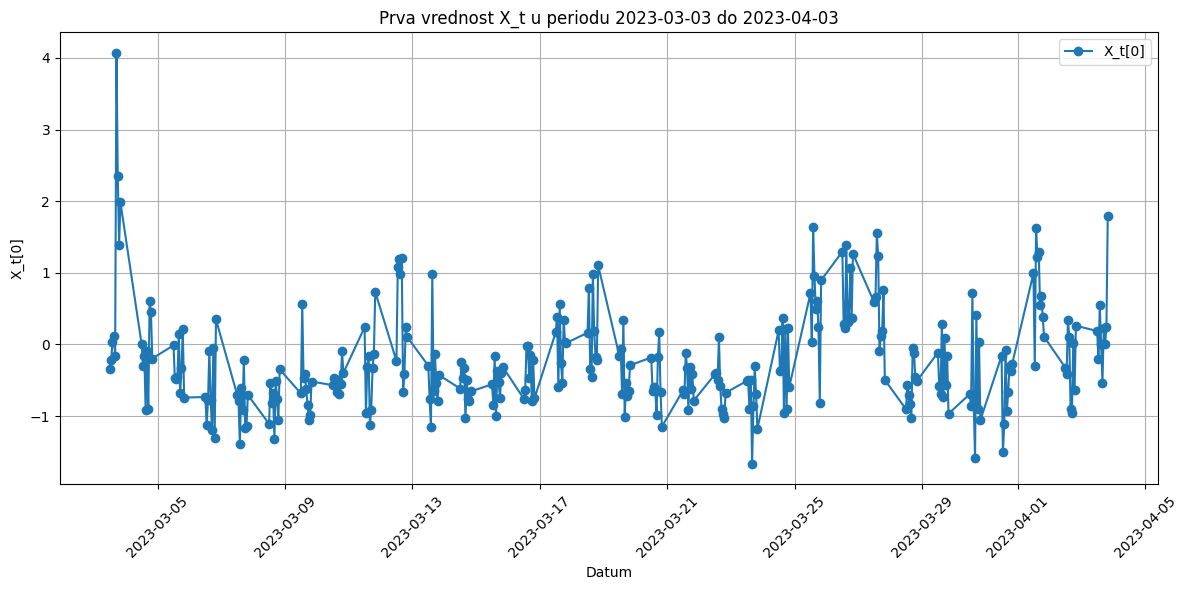

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Pretpostavljam da koristiš df_with_tensors
df_with_tensors['TIMESTAMP'] = pd.to_datetime(df_with_tensors['TIMESTAMP'])

start_date = pd.to_datetime('2023-03-03')
end_date = pd.to_datetime('2023-04-03 23:59:59')  # uključujemo ceo dan

# Filtriraj podatke iz df_with_tensors
filtered_df = df_with_tensors[
    (df_with_tensors['TIMESTAMP'] >= start_date) &
    (df_with_tensors['TIMESTAMP'] <= end_date)
]

# Ako je filtrirani DataFrame prazan, prijavi to
if filtered_df.empty:
    print("Nema podataka za dati vremenski opseg:", start_date, "do", end_date)
else:
    # Prvu vrednost iz svakog X_t tensora
    first_values = [
        x[0].item() if isinstance(x, torch.Tensor) else x[0]
        for x in filtered_df['X_t']
    ]

    # Vizualizacija
    plt.figure(figsize=(12, 6))
    plt.plot(filtered_df['TIMESTAMP'], first_values, marker='o', linestyle='-', label='X_t[0]')
    plt.title(f'Prva vrednost X_t u periodu {start_date.date()} do {end_date.date()}')
    plt.xlabel('Datum')
    plt.ylabel('X_t[0]')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Vizualizacija statistika kasnjenja

/tmp/ipython-input-117-3703565897.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_tensors['TIMESTAMP'] = pd.to_datetime(df_with_tensors['TIMESTAMP'])
/tmp/ipython-input-117-3703565897.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_tensors['X_t_0'] = df_with_tensors['X_t'].apply(


Statistika za X_t[0]:
- Prosek (mean): 0.2162
- Standardna devijacija: 1.0382
- Minimum: -2.3172
- Maksimum: 5.3427


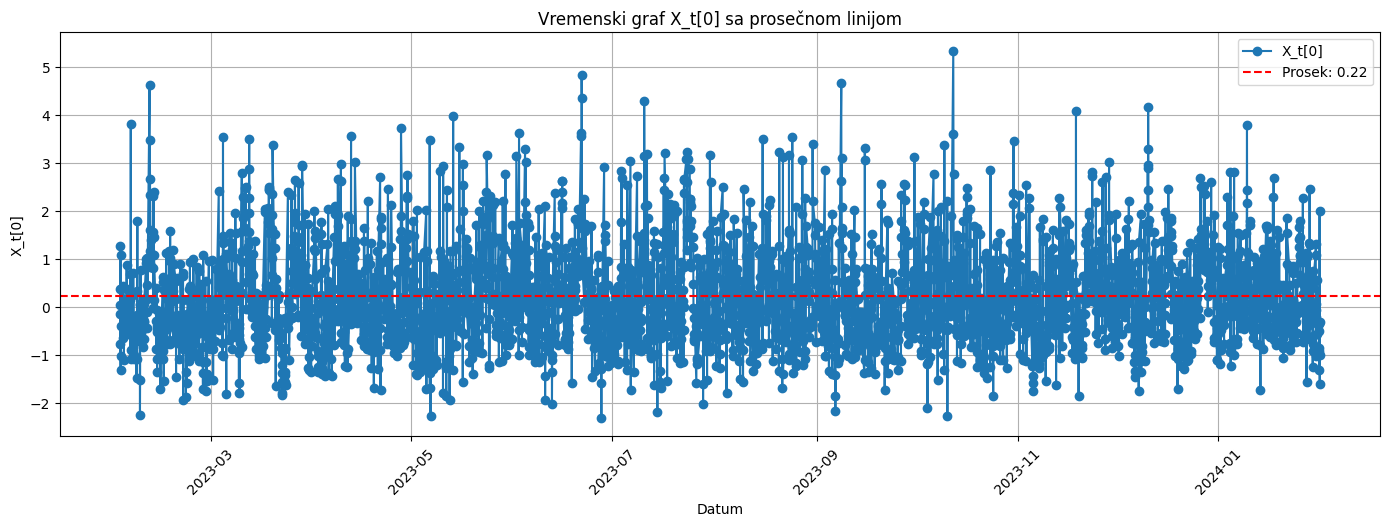

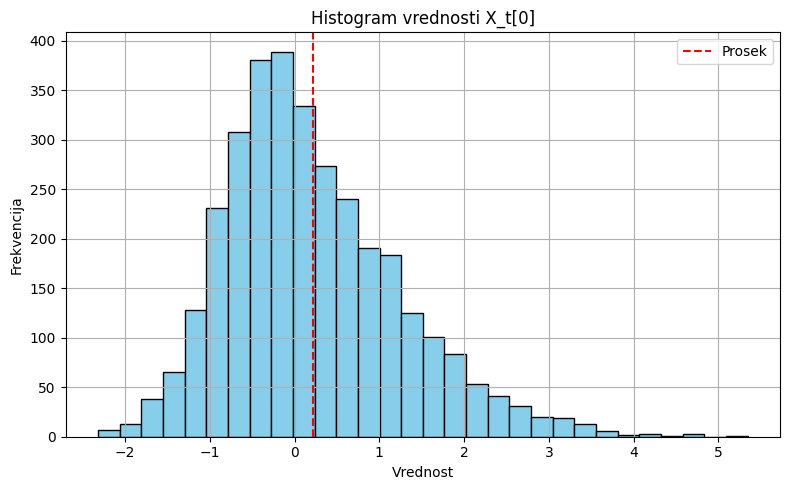

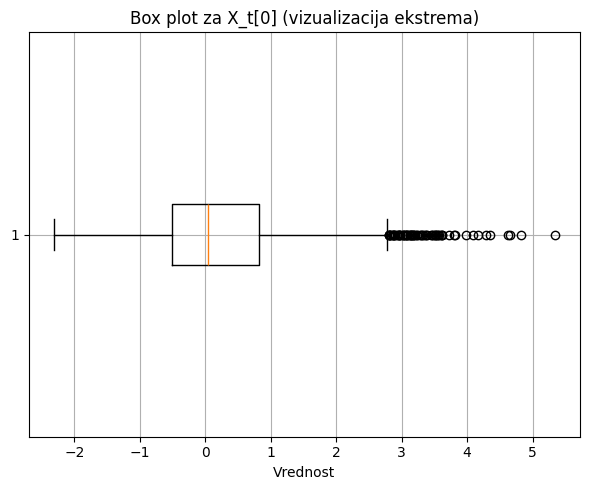

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import torch

df_with_tensors['TIMESTAMP'] = pd.to_datetime(df_with_tensors['TIMESTAMP'])

# Prvu vrednost iz svakog X_t
df_with_tensors['X_t_0'] = df_with_tensors['X_t'].apply(
    lambda x: x[34].item() if isinstance(x, torch.Tensor) else x[34]
)

# Statistika
mean_val = df_with_tensors['X_t_0'].mean()
std_val = df_with_tensors['X_t_0'].std()
min_val = df_with_tensors['X_t_0'].min()
max_val = df_with_tensors['X_t_0'].max()

print("Statistika za X_t[0]:")
print(f"- Prosek (mean): {mean_val:.4f}")
print(f"- Standardna devijacija: {std_val:.4f}")
print(f"- Minimum: {min_val:.4f}")
print(f"- Maksimum: {max_val:.4f}")

#  Linijski graf sa prosečnom linijom
plt.figure(figsize=(14, 5))
plt.plot(df_with_tensors['TIMESTAMP'], df_with_tensors['X_t_0'], label='X_t[0]', marker='o')
plt.axhline(mean_val, color='red', linestyle='--', label=f'Prosek: {mean_val:.2f}')
plt.title('Vremenski graf X_t[0] sa prosečnom linijom')
plt.xlabel('Datum')
plt.ylabel('X_t[0]')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

#  Histogram
plt.figure(figsize=(8, 5))
plt.hist(df_with_tensors['X_t_0'], bins=30, color='skyblue', edgecolor='black')
plt.axvline(mean_val, color='red', linestyle='--', label='Prosek')
plt.title('Histogram vrednosti X_t[0]')
plt.xlabel('Vrednost')
plt.ylabel('Frekvencija')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#  Box plot
plt.figure(figsize=(6, 5))
plt.boxplot(df_with_tensors['X_t_0'], vert=False)
plt.title('Box plot za X_t[0] (vizualizacija ekstrema)')
plt.xlabel('Vrednost')
plt.grid(True)
plt.tight_layout()
plt.show()


Podaci su pripremljeni.

# **Formiranje DataLoader-a za model**

In [118]:
import torch
from torch.utils.data import Dataset


class FlightPredictionDataLoader(Dataset):
    def __init__(self, X_t, W_in, W_out, A, Y_t):
        self.X_t    = X_t        # sekvenca
        self.W_in   = W_in     #in matrica
        self.W_out  = W_out     # out matrica
        self.A = A  #grupna Adj matrica
        self.Y_t  = Y_t #predvidjanje


    def __len__(self):
        return len(self.X_t)

    def __getitem__(self, t):
        return self.X_t[t], self.W_in[t], self.W_out[t], self.A[t], self.Y_t[t]

DataLoader_prepared = FlightPredictionDataLoader(
    torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in df_with_tensors['time_series']]), # X_t predstavlja time series
    torch.stack([torch.tensor(w_in, dtype=torch.float32) for w_in in df_adj["W_in"]]),
    torch.stack([torch.tensor(w_out, dtype=torch.float32) for w_out in df_adj["W_out"]]),
    torch.stack([torch.tensor(a, dtype=torch.float32) for a in df_adj["A"]]),
    torch.stack([torch.tensor(y, dtype=torch.float32) for y in df_with_tensors["X_t"]]))   # pretpostavljam da je y cilj


/tmp/ipython-input-118-3676924790.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.stack([torch.tensor(arr, dtype=torch.float32) for arr in df_with_tensors['time_series']]), # X_t predstavlja time series
/tmp/ipython-input-118-3676924790.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.stack([torch.tensor(y, dtype=torch.float32) for y in df_with_tensors["X_t"]]))   # pretpostavljam da je y cilj


In [119]:
from torch.utils.data import DataLoader


dataloader = DataLoader(DataLoader_prepared, batch_size=4, shuffle=True)
for batch in dataloader:
    X_t_batch, W_in_batch, W_out_batch, A_batch, Y_t_batch = batch

    print("X_t shape:", X_t_batch.shape)        # očekujemo (batch_size, num_nodes, in_channels)
    print("W_in shape:", W_in_batch.shape)      # (batch_size, num_nodes, num_nodes)
    print("W_out shape:", W_out_batch.shape)    # (batch_size, num_nodes, num_nodes)
    print("A shape:", A_batch.shape)             # (batch_size, num_nodes, num_nodes) ili slično
    print("Y_t shape:", Y_t_batch.shape)        # (batch_size, num_nodes) ili (batch_size, num_nodes, neki dim)
    break  # ne treba ti više od jednog primera za proveru


X_t shape: torch.Size([4, 63, 35])
W_in shape: torch.Size([4, 35, 35])
W_out shape: torch.Size([4, 35, 35])
A shape: torch.Size([4, 35, 35])
Y_t shape: torch.Size([4, 35])


# **ARHITEKTURA MREZE**

Potrebno je napraviti graf koji sadrzi sledece:

-Ulaz -> X_t W_in i W_out


---


|
-TemporalConvolutionalBlock_1


---


|
-AdaptiveGraphConvolutionalBlock_1


---


|
-TemporalConvolutionalBlock_2

---

|
-AdaptiveGraphConvolutionalBlock_2

---

|
-linear

---


|
-output (prediction)

**Formiranje TemporalConvolutionalBlock arhitekture**

Neuronska mreza se sastoji od RGCN sloja i sloja RNN

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.M_in = nn.Parameter(torch.randn(35, 35))
        self.M_out = nn.Parameter(torch.randn(35, 35))

    def forward(self, X_t, W_in, W_out):
        device = W_in.device  # dobija device iz W_in
        I_in = torch.eye(W_in.shape[1], device=device)  # napravi eye na istom device-u
        D_in_tmp = W_in + I_in
        row_sums_in = D_in_tmp.sum(dim=1)
        D_in = torch.diag_embed(row_sums_in)
        D_in_inv = torch.diag_embed(torch.where(row_sums_in == 0, row_sums_in, 1.0 / row_sums_in))
        X_t = X_t.permute(0, 2, 1)

        out_in = D_in @ D_in_inv @ X_t

        out_in = out_in.permute(0, 2 ,1)

        out_in = out_in @ self.M_in

        I_out = torch.eye(W_out.shape[1], device=device)  # napravi eye na istom device-u
        D_out_tmp = W_out + I_out
        row_sums_out = D_out_tmp.sum(dim=1)
        D_out = torch.diag_embed(row_sums_out)
        D_out_inv = torch.diag_embed(torch.where(row_sums_out == 0, row_sums_out, 1.0 / row_sums_out))

        out_out = D_out @ D_out_inv @ X_t
        out_out = out_out.permute(0, 2, 1)
        out_out = out_out @ self.M_out
        out = out_in + out_out
        return F.relu(out)


class RecurentRGCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(RecurentRGCN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.RGCN= RGCNLayer(in_channels, out_channels)
        self.activation =   nn.ReLU()
        self.linear = nn.Linear(in_channels, 1)

    def forward(self, X_n, W_in, W_out, H_t_prev):
        out = self.RGCN(X_n, W_in, W_out)  # (B, N, C)
        # Direktno saberi ako su oba oblika (B, N, C)
        out = out.permute(0,2,1)
        H_last = H_t_prev + out           # (B, N, C)
        H_last = self.activation(H_last)
        #out = self.linear(out)           # (B, 1, N)
        out = out.squeeze(1)             # (B, N)
        return out, H_last

**AdaptiveGraphConvolutionalBlock**

Blok se sastoji iz
SpatialGCN


---


BN_1


---


ReLU_1


---


Dropout

---


TemporalGCN

---


BN

---


ReLU

---


residual


In [37]:
class SpatialGCN(nn.Module):
    def __init__(self, in_channels, out_channels, num_nodes):
        super(SpatialGCN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_nodes = num_nodes
        self.theta = nn.Parameter(torch.randn(num_nodes, num_nodes))
        self.Z = nn.Parameter(torch.randn(num_nodes, num_nodes))

        self.phi = nn.Conv1d(63, 63, kernel_size=1)
        self.psi = nn.Conv1d(63, 63, kernel_size=1)
        self.linear = nn.Linear(out_channels, 1)
        self.bn = nn.BatchNorm1d(35)
        self.dropout = nn.Dropout(0.3)

    def forward(self, H_last, A):
        batch_size = H_last.shape[0]
        row_sums = A.sum(dim=2)  # suma po kolonama tj dim=2 (jer A je batch x n x n)
        Q = torch.diag_embed(row_sums)  # shape: (batch_size, num_nodes, num_nodes)


        Q_inv = torch.diag_embed(1.0 / (row_sums + 1e-6))  # izbegavamo deljenje nulom
        I = torch.eye(self.num_nodes, device=H_last.device).unsqueeze(0).repeat(batch_size, 1, 1)  # batch x n x n
        H_last = H_last.permute(0,2,1)
        phi_H = self.phi(H_last)  # (batch_size, out_channels, num_nodes)
        psi_H = self.psi(H_last)  # (batch_size, out_channels, num_nodes)
        phi_H_t = phi_H #.permute(0, 2, 1)  # batch x num_nodes x out_channels
        psi_H_t = psi_H #.permute(0, 2, 1)  # batch x num_nodes x out_channels

        H_last_transponse = H_last.transpose(1, 2)
        S_prem_1 = torch.bmm( psi_H_t, phi_H_t.transpose(1, 2))  # batch x num_nodes x num_nodes
    #     #print("1", S_prem_1.shape)
    #     #print("H_last_transponse", H_last_transponse.shape)
        S_prem_2 = torch.bmm(H_last_transponse, S_prem_1)
    #    # print("2", S_prem_2.shape)
    #    # print("H_last", H_last.shape)
        S_prem_3 = torch.bmm(S_prem_2, H_last)
    #    # print("3", S_prem_3.shape)
        S = torch.softmax(S_prem_3, dim=-1)  # softmax po poslednjoj dimenziji (po koloni)
        Z_batch = self.Z.unsqueeze(0).repeat(batch_size, 1, 1)  # batch x n x n
    #     #print("A : ", A.shape)

        # #print("S : ", S.shape)
        M = A +  Z_batch + S# batch x n x n

        temp = torch.bmm(Q_inv, M)  # batch x n x n
        left = I + temp  # batch x n x n

        H_last_t = H_last.permute(0, 2, 1)  # batch x num_nodes x in_channels
        out_t = torch.bmm(M, H_last_t)  # batch x num_nodes x in_channels

        theta_batch = self.theta.unsqueeze(0).expand(batch_size, -1, -1)  # (batch_size, num_nodes, num_nodes)

        out_t = torch.bmm(theta_batch, H_last.permute(0,2,1))  # (batch_size, num_nodes, in_channels)

        out = out_t#.permute(0, 2, 1)  # batch x in_channels x num_nodes

        #out = self.linear(out)
        #out = out.squeeze(-1)
        out = self.bn(out)
        out = torch.relu(out)
        out = self.dropout(out)
        return out


In [38]:
def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    nn.init.constant_(conv.bias, 0)


def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)


class TemporalGCN(nn.Module):
  "https://github.com/lshiwjx/2s-AGCN/blob/master/model/agcn.py"
  def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
      super(TemporalGCN, self).__init__()
      pad = int((kernel_size - 1) / 2)
      self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                            stride=(stride, 1))

      self.bn = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU()
      conv_init(self.conv)
      bn_init(self.bn, 1)

  def forward(self, x):
      x = self.bn(self.conv(x))
      return x


In [39]:
class AdaptiveGraphConvolutionalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_nodes, dropout_rate=0.3):
        super().__init__()
        self.dropout_rate = dropout_rate
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.spatial_gcn = SpatialGCN(in_channels, out_channels, num_nodes)
        self.bn = nn.BatchNorm1d(out_channels)
        self.dropout = nn.Dropout(dropout_rate)
        self.temporal_gcn = TemporalGCN(out_channels, out_channels)

        if in_channels != out_channels:
            self.residual_conv = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = nn.Identity()

    def forward(self, H_t, A):
        # H_t: (batch, in_channels, num_nodes)

        residual = self.residual_conv(H_t)  # (batch, out_channels, num_nodes)
        out = self.spatial_gcn(H_t.permute(0,2,1), A)      # (batch, out_channels, num_nodes)
        # Permutujemo da batchnorm radi po kanalu (BatchNorm1d prima shape (B, C, L))
        # Trenutno out je (B, C, N), a BatchNorm1d zahteva (B, C, L)
        # Ako želiš BatchNorm preko čvorova, moraš permutovati, ali obično radi po kanalu
        # Kod BatchNorm1d za (B, C, L), normalizacija ide po C, dakle ostaje isti shape
        # Ako želiš normalizovati po čvorovima, onda treba permutovati (B, N, C), ali onda BatchNorm1d treba da ima num_features=N
        # Zato možemo izostaviti permutaciju i koristiti BatchNorm1d sa out_channels kao feature dimenzijom
        out = out.permute(0,2,1)
       # print("AAAAAAAAAAAAAAAAAAAAAAAAAAAA")
        # Dakle ovde NIJE potrebna permutacija pre batchnorma (osim ako tvoj SpatialGCN vraća drugi oblik)
        out = self.bn(out)                   # (batch, out_channels, num_nodes)
        #print("AAAAAAAAAAAAAAAAAAAAAAAAAAAA")
        out = self.dropout(out)
      #  print("AAAAAAAAAAAAAAAAAAAAAAAAAAAA")
        # Dodaj dimenziju T=1 za temporalni sloj

        out = out.unsqueeze(2)               # (batch, out_channels, T=1, num_nodes)
      #  print("AAAAAAAAAAAAAAAAAAAAAAAAAAAA")
        out = self.temporal_gcn(out)        # (batch, out_channels, T=1, num_nodes)
      #  print("AAAAAAAAAAAAAAAAAAAAAAAAAAAA")
        out = out.squeeze(2)                 # (batch, out_channels, num_nodes)
      #  print("AAAAAAAAAAAAAAAAAAAAAAAAAAAA")
        out = out + residual                 # Skip connection

        return out

**Formiranje cele MSTAGCN arhitekture**

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MSTAGCN(nn.Module):
    def __init__(self, in_channels, hidden_size, out_channels, kernel_size=5, num_nodes=35):
        super(MSTAGCN, self).__init__()
        self.in_channels = in_channels
        self.hidden_size = hidden_size
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.num_nodes = num_nodes

        self.temporalConvolutionalBlock1 = RecurentRGCN(in_channels=in_channels, out_channels=hidden_size)
        self.adaptiveGraphConvolutionalBlock_1 = AdaptiveGraphConvolutionalBlock(in_channels=hidden_size, out_channels=hidden_size, num_nodes=num_nodes)
        self.temporalConvolutionalBlock2 = RecurentRGCN(in_channels=hidden_size, out_channels=hidden_size)
        self.adaptiveGraphConvolutionalBlock_2 = AdaptiveGraphConvolutionalBlock(in_channels=hidden_size, out_channels=hidden_size, num_nodes=num_nodes)
        self.lin1 = nn.Linear(num_nodes, 63)  # proveri da li je ovo dimenzionalno ispravno
        self.lin2 = nn.Linear(63, 1)

    # Za sada koristim samo jedna sloj RNN i jedan sloj AGCN
    def forward(self, X_t, W_in, W_out, A, H_t_prev_1):
        # X_t: (batch, in_channels, num_nodes)
        # Prvi rekurentni sloj
        out_rnn1, H_t_1 = self.temporalConvolutionalBlock1(X_t, W_in, W_out, H_t_prev_1)
        # Samo JEDNA permutacija (B, C, N) -> (B, N, C)
        out = self.adaptiveGraphConvolutionalBlock_1(H_t_1.permute(0, 2, 1), A)  # (B, C, N)

        # Lin1 očekuje (B, C, N), dakle permutacija NIJE potrebna ako C = num_nodes
        # out_seq = out  # (B, C, N)
        # #out_seq = self.lin1(out_seq)  # (B, C, 69)
        # # Sad imamo (B, C, 69) → želimo da permutujemo u (B, 69, C) pre drugog sloja
        # #out_seq = out_seq.permute(0, 2, 1)  # (B, 69, C)
        # # Drugi rekurentni sloj
        # out_rnn2, H_t_2 = self.temporalConvolutionalBlock2(out_seq, W_in, W_out, H_t_prev_2)
        # # Samo JEDNA permutacija za H_t_2
        # out = self.adaptiveGraphConvolutionalBlock_2(H_t_2.permute(0, 2, 1), A)  # (B, C, N)


        # Linear sloj za finalni izlaz
        out = out.permute(0, 2 ,1)
        out = self.lin2(out)  # (B, C, 1)
        out = out.squeeze(-1)
        return out, H_t_1#, H_t_2  # (B, C), bez višestrukih permutacija

# **Treniranje modela**

# **MSTAGCN**

In [41]:
import torch
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

batch_size = 64
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_size = len(DataLoader_prepared)

# Podela na train / val / test
train_end = int(0.7 * dataset_size)
val_end = train_end + int(0.15 * dataset_size)

train_indices = list(range(0, train_end))
val_indices = list(range(train_end, val_end))
test_indices = list(range(val_end, dataset_size))

train_dataset = Subset(DataLoader_prepared, train_indices)
val_dataset = Subset(DataLoader_prepared, val_indices)
test_dataset = Subset(DataLoader_prepared, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Inicijalizacija modela (pretpostavljam da si dodao Dropout u model)
model = MSTAGCN(in_channels=63, hidden_size=63, out_channels=63)
model.to(device)

# Manji lr + veći weight decay
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.6)
criterion = torch.nn.MSELoss()

# Early stopping parametri
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_t, W_in, W_out, A, Y_t in train_loader:
        X_t = X_t.float().to(device)
        W_in = W_in.float().to(device)
        W_out = W_out.float().to(device)
        A = A.float().to(device)
        Y_t = Y_t.float().to(device)

        batch_size_current = X_t.size(0)
        H_t_prev = torch.zeros(batch_size_current, model.num_nodes, model.hidden_size).to(device)

        optimizer.zero_grad()
        y_pred, H_t_prev = model(X_t, W_in, W_out, A, H_t_prev)
        loss = criterion(y_pred, Y_t)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size_current

    train_loss /= len(train_dataset)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_t, W_in, W_out, A, Y_t in val_loader:
            X_t = X_t.float().to(device)
            W_in = W_in.float().to(device)
            W_out = W_out.float().to(device)
            A = A.float().to(device)
            Y_t = Y_t.float().to(device)

            batch_size_current = X_t.size(0)
            H_t_prev = torch.zeros(batch_size_current, model.num_nodes, model.hidden_size).to(device)

            y_pred, H_t_prev = model(X_t, W_in, W_out, A, H_t_prev)
            loss = criterion(y_pred, Y_t)
            val_loss += loss.item() * batch_size_current

    val_loss /= len(val_dataset)
    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    scheduler.step()

    # Early stopping logika
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")  # čuvamo najbolji model
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Epoch 001 | Train Loss: 2.6773 | Val Loss: 1.0838
Epoch 002 | Train Loss: 1.0229 | Val Loss: 1.0027
Epoch 003 | Train Loss: 1.0006 | Val Loss: 1.0013
Epoch 004 | Train Loss: 0.9978 | Val Loss: 0.9995
Epoch 005 | Train Loss: 0.9882 | Val Loss: 0.9987
Epoch 006 | Train Loss: 0.9784 | Val Loss: 0.9989
Epoch 007 | Train Loss: 0.9758 | Val Loss: 0.9987
Epoch 008 | Train Loss: 0.9749 | Val Loss: 0.9997
Epoch 009 | Train Loss: 0.9737 | Val Loss: 1.0000
Epoch 010 | Train Loss: 0.9725 | Val Loss: 1.0001
Epoch 011 | Train Loss: 0.9702 | Val Loss: 0.9993
Epoch 012 | Train Loss: 0.9677 | Val Loss: 0.9994
Epoch 013 | Train Loss: 0.9640 | Val Loss: 0.9960
Epoch 014 | Train Loss: 0.9593 | Val Loss: 0.9938
Epoch 015 | Train Loss: 0.9528 | Val Loss: 0.9862
Epoch 016 | Train Loss: 0.9452 | Val Loss: 0.9859
Epoch 017 | Train Loss: 0.9392 | Val Loss: 0.9835
Epoch 018 | Train Loss: 0.9330 | Val Loss: 0.9786
Epoch 019 | Train Loss: 0.9289 | Val Loss: 0.9739
Epoch 020 | Train Loss: 0.9203 | Val Loss: 0.9682


**Vizualizacija rezultata**


📉 MSE po čvorovima:
Node 0: 0.3380
Node 1: 1.2996
Node 2: 0.7027
Node 3: 0.6768
Node 4: 0.7915
Node 5: 0.8754
Node 6: 0.9401
Node 7: 0.7658
Node 8: 0.5640
Node 9: 0.8411
Node 10: 0.6634
Node 11: 0.8764
Node 12: 1.2091
Node 13: 2.2475
Node 14: 1.9627
Node 15: 0.9101
Node 16: 1.0020
Node 17: 0.8589
Node 18: 0.6543
Node 19: 0.7670
Node 20: 0.5027
Node 21: 1.0219
Node 22: 0.8292
Node 23: 0.7503
Node 24: 0.5321
Node 25: 1.2538
Node 26: 1.2075
Node 27: 0.6616
Node 28: 0.7099
Node 29: 0.9560
Node 30: 0.7729
Node 31: 1.1709
Node 32: 1.1198
Node 33: 0.9917
Node 34: 0.8568

🔎 R² skor (svi čvorovi i uzorci): 0.0776


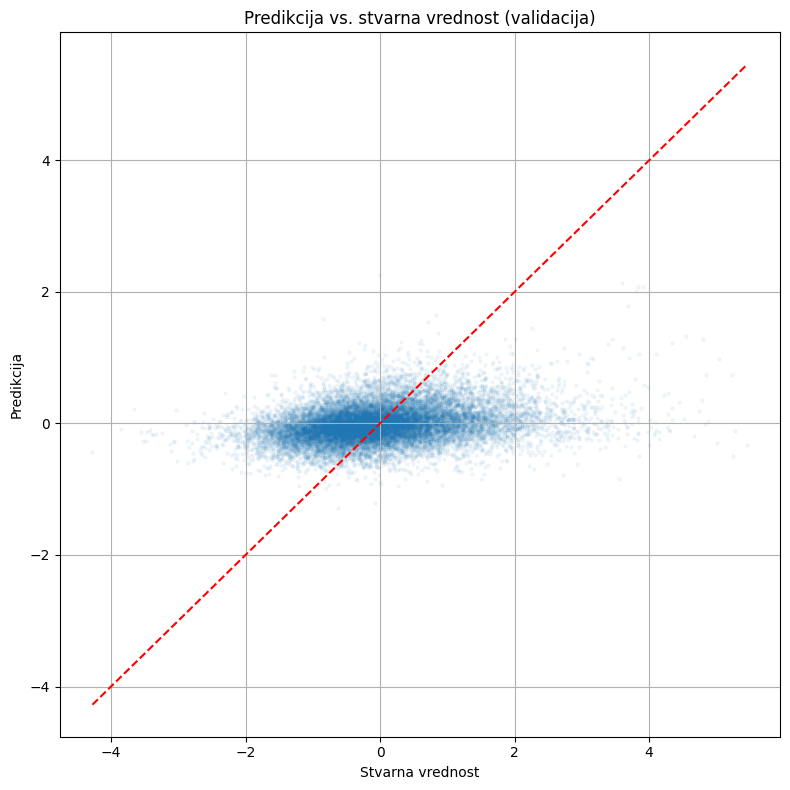

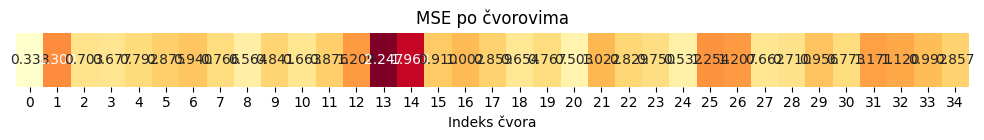

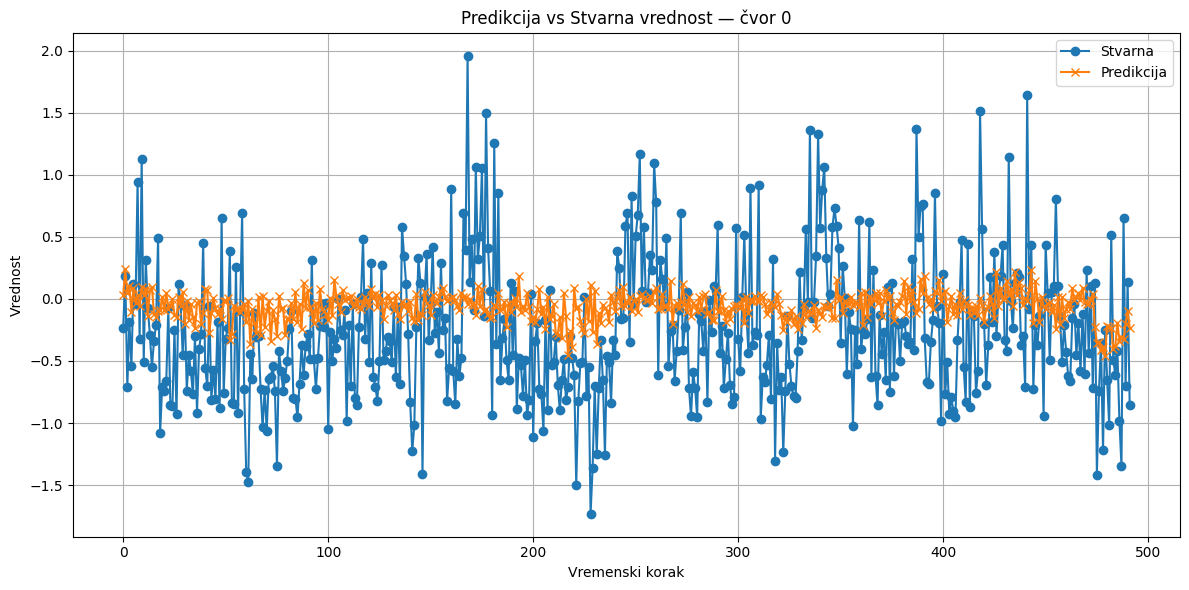

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_and_visualize(model, val_loader, device='cuda'):
    model.eval()
    criterion = torch.nn.MSELoss(reduction='none')
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_t, W_in, W_out, A, Y_t in val_loader:
            X_t, W_in, W_out, A, Y_t = [x.float().to(device) for x in (X_t, W_in, W_out, A, Y_t)]
            H_t_prev = torch.zeros(X_t.size(0), model.num_nodes, model.hidden_size).to(device)

            y_pred, _ = model(X_t, W_in, W_out, A, H_t_prev)

            if y_pred.dim() == 3:
                y_pred = y_pred.squeeze(1)
            if Y_t.dim() == 3:
                Y_t = Y_t.squeeze(1)

            all_y_true.append(Y_t.cpu())
            all_y_pred.append(y_pred.cpu())

    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()

    # MSE po čvorovima
    mse_per_node = np.mean((all_y_true - all_y_pred) ** 2, axis=0)
    print("\n MSE po čvorovima:")
    for i, mse_val in enumerate(mse_per_node):
        print(f"Node {i}: {mse_val:.4f}")

    # R² skor
    def r2_score(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

    r2 = r2_score(all_y_true.flatten(), all_y_pred.flatten())
    print(f"\n R² skor (svi čvorovi i uzorci): {r2:.4f}")

    # === VIZUALIZACIJE ===

    # 1. Scatter plot
    plt.figure(figsize=(8, 8))
    plt.scatter(all_y_true.flatten(), all_y_pred.flatten(), alpha=0.05, s=5)
    plt.plot([all_y_true.min(), all_y_true.max()],
             [all_y_true.min(), all_y_true.max()], 'r--')
    plt.xlabel("Stvarna vrednost")
    plt.ylabel("Predikcija")
    plt.title("Predikcija vs. stvarna vrednost (validacija)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Heatmap MSE po čvorovima
    plt.figure(figsize=(10, 1.5))
    sns.heatmap(mse_per_node[np.newaxis, :], cmap="YlOrRd", annot=True, fmt=".3f", cbar=False)
    plt.yticks([])
    plt.title("MSE po čvorovima")
    plt.xlabel("Indeks čvora")
    plt.tight_layout()
    plt.show()

    # 3. Linijski graf za jedan čvor
    node_idx = 0  # možeš menjati
    plt.figure(figsize=(12, 6))
    plt.plot(all_y_true[:, node_idx], label='Stvarna', marker='o')
    plt.plot(all_y_pred[:, node_idx], label='Predikcija', marker='x')
    plt.title(f'Predikcija vs Stvarna vrednost — čvor {node_idx}')
    plt.xlabel('Vremenski korak')
    plt.ylabel('Vrednost')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
evaluate_and_visualize(model, val_loader, device='cuda')

In [43]:
!pip install torchinfo
!pip install torch torchvision
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [44]:

from torchinfo import summary
summary(model)


Layer (type:depth-idx)                        Param #
MSTAGCN                                       --
├─RecurentRGCN: 1-1                           --
│    └─RGCNLayer: 2-1                         2,450
│    └─ReLU: 2-2                              --
│    └─Linear: 2-3                            64
├─AdaptiveGraphConvolutionalBlock: 1-2        --
│    └─SpatialGCN: 2-4                        2,450
│    │    └─Conv1d: 3-1                       4,032
│    │    └─Conv1d: 3-2                       4,032
│    │    └─Linear: 3-3                       64
│    │    └─BatchNorm1d: 3-4                  70
│    │    └─Dropout: 3-5                      --
│    └─BatchNorm1d: 2-5                       126
│    └─Dropout: 2-6                           --
│    └─TemporalGCN: 2-7                       --
│    │    └─Conv2d: 3-6                       19,908
│    │    └─BatchNorm2d: 3-7                  126
│    │    └─ReLU: 3-8                         --
│    └─Identity: 2-8                          

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

Launching TensorBoard...

# **TRENIRANJE ZASEBNIH MODELA**

U narednom radu predstavicemo kako svaki od blokova nezavisno treniran mrezu.

**TRENIRANJE SAMO REKURENTNOG RGCN BLOKA**

In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RGCNLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.M_in = nn.Parameter(torch.randn(35, 35))
        self.M_out = nn.Parameter(torch.randn(35, 35))

    def forward(self, X_t, W_in, W_out):
        device = W_in.device  # dobija device iz W_in
        I_in = torch.eye(W_in.shape[1], device=device)  # napravi eye na istom device-u
        D_in_tmp = W_in + I_in
        row_sums_in = D_in_tmp.sum(dim=1)
        D_in = torch.diag_embed(row_sums_in)
        D_in_inv = torch.diag_embed(torch.where(row_sums_in == 0, row_sums_in, 1.0 / row_sums_in))
        X_t = X_t.permute(0, 2, 1)
        out_in = D_in @ D_in_inv @ X_t
        out_in = out_in.permute(0, 2 ,1)
        out_in = out_in @ self.M_in
        I_out = torch.eye(W_out.shape[1], device=device)  # napravi eye na istom device-u
        D_out_tmp = W_out + I_out
        row_sums_out = D_out_tmp.sum(dim=1)
        D_out = torch.diag_embed(row_sums_out)
        D_out_inv = torch.diag_embed(torch.where(row_sums_out == 0, row_sums_out, 1.0 / row_sums_out))

        out_out = D_out @ D_out_inv @ X_t
        out_out = out_out.permute(0, 2, 1)
        out_out = out_out @ self.M_out
        out = out_in + out_out
        return F.relu(out)
class RecurentRGCN(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(RecurentRGCN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.RGCN= RGCNLayer(in_channels, out_channels)
        self.activation =   nn.ReLU()
        self.linear = nn.Linear(in_channels, 1)

    def forward(self, X_n, W_in, W_out, H_t_prev):
        out = self.RGCN(X_n, W_in, W_out)  # (B, N, C)
        # Direktno saberi ako su oba oblika (B, N, C)
        #out = out.permute(0,2,1)
        H_last = H_t_prev + out           # (B, N, C)
        H_last = self.activation(H_last)
        out = self.linear(out.permute(0,2,1))           # (B, 1, N)
        out = out.squeeze(1)             # (B, N)
        return out, H_last

In [123]:
import torch
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Hiperparametri
batch_size = 64
num_epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset split
dataset_size = len(DataLoader_prepared)
train_end = int(0.7 * dataset_size)
val_end = train_end + int(0.15 * dataset_size)

train_indices = list(range(0, train_end))
val_indices = list(range(train_end, val_end))
test_indices = list(range(val_end, dataset_size))

train_dataset = Subset(DataLoader_prepared, train_indices)
val_dataset = Subset(DataLoader_prepared, val_indices)
test_dataset = Subset(DataLoader_prepared, test_indices)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Inicijalizacija modela
in_channels = 63
model = RecurentRGCN(in_channels=in_channels, out_channels=in_channels)
model.to(device)

# Optimizator i scheduler
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=5, gamma=0.6)
criterion = torch.nn.MSELoss()

# Early stopping
best_val_loss = float('inf')
patience = 20
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_t, W_in, W_out, A, Y_t in train_loader:
        X_t = X_t.float().to(device)         # (B, N, C)
        W_in = W_in.float().to(device)       # (B, N, N)
        W_out = W_out.float().to(device)
        Y_t = Y_t.float().to(device)         # (B, N)

        batch_size_current = X_t.size(0)
        num_nodes = 35
        H_t_prev = torch.zeros(batch_size_current, in_channels, num_nodes).to(device)  # (B, C, N)

        optimizer.zero_grad()
        y_pred, _ = model(X_t, W_in, W_out, H_t_prev)
        y_pred = y_pred.squeeze(-1)
        loss = criterion(y_pred, Y_t)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch_size_current

    train_loss /= len(train_dataset)

    # Validacija
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_t, W_in, W_out, A, Y_t in val_loader:
            X_t = X_t.float().to(device)
            W_in = W_in.float().to(device)
            W_out = W_out.float().to(device)
            Y_t = Y_t.float().to(device)

            batch_size_current = X_t.size(0)
            num_nodes = 35
            H_t_prev = torch.zeros(batch_size_current, in_channels, num_nodes).to(device)
            y_pred, _ = model(X_t, W_in, W_out, H_t_prev)
            y_pred = y_pred.squeeze(-1)
            loss = criterion(y_pred, Y_t)
            val_loss += loss.item() * batch_size_current

    val_loss /= len(val_dataset)
    print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    scheduler.step()

    # Early stopping
    if val_loss < best_val_loss - 1e-4:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_recurrent_rgcn.pt")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break


Epoch 001 | Train Loss: 2.3004 | Val Loss: 1.0457
Epoch 002 | Train Loss: 1.0183 | Val Loss: 1.0023
Epoch 003 | Train Loss: 0.9999 | Val Loss: 0.9995
Epoch 004 | Train Loss: 0.9981 | Val Loss: 0.9989
Epoch 005 | Train Loss: 0.9958 | Val Loss: 0.9968
Epoch 006 | Train Loss: 0.9916 | Val Loss: 0.9941
Epoch 007 | Train Loss: 0.9857 | Val Loss: 0.9881
Epoch 008 | Train Loss: 0.9749 | Val Loss: 0.9765
Epoch 009 | Train Loss: 0.9587 | Val Loss: 0.9583
Epoch 010 | Train Loss: 0.9417 | Val Loss: 0.9390
Epoch 011 | Train Loss: 0.9290 | Val Loss: 0.9287
Epoch 012 | Train Loss: 0.9200 | Val Loss: 0.9183
Epoch 013 | Train Loss: 0.9110 | Val Loss: 0.9072
Epoch 014 | Train Loss: 0.9023 | Val Loss: 0.8992
Epoch 015 | Train Loss: 0.8937 | Val Loss: 0.8900
Epoch 016 | Train Loss: 0.8864 | Val Loss: 0.8850
Epoch 017 | Train Loss: 0.8816 | Val Loss: 0.8783
Epoch 018 | Train Loss: 0.8770 | Val Loss: 0.8746
Epoch 019 | Train Loss: 0.8729 | Val Loss: 0.8718
Epoch 020 | Train Loss: 0.8690 | Val Loss: 0.8668



 MSE po čvorovima:
Čvor 00: 0.3960
Čvor 01: 0.9517
Čvor 02: 0.6635
Čvor 03: 0.6215
Čvor 04: 0.7669
Čvor 05: 0.7900
Čvor 06: 0.8549
Čvor 07: 0.7141
Čvor 08: 0.5804
Čvor 09: 0.8926
Čvor 10: 0.6735
Čvor 11: 0.6577
Čvor 12: 1.1352
Čvor 13: 2.0148
Čvor 14: 1.7848
Čvor 15: 0.8352
Čvor 16: 0.8058
Čvor 17: 0.9959
Čvor 18: 0.5028
Čvor 19: 0.6074
Čvor 20: 0.5492
Čvor 21: 0.8357
Čvor 22: 0.7740
Čvor 23: 0.7476
Čvor 24: 0.5275
Čvor 25: 0.9927
Čvor 26: 1.0743
Čvor 27: 0.5627
Čvor 28: 0.7579
Čvor 29: 0.8830
Čvor 30: 0.7056
Čvor 31: 1.0978
Čvor 32: 1.1310
Čvor 33: 0.9411
Čvor 34: 0.8563
R² skor (svi čvorovi): 0.1520


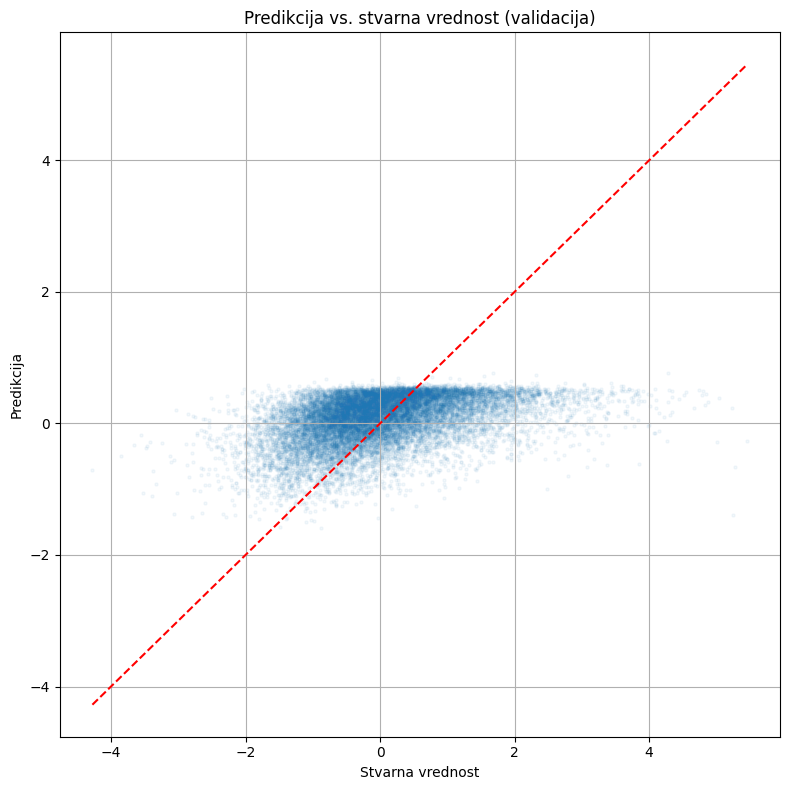

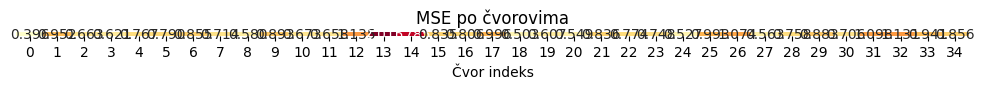

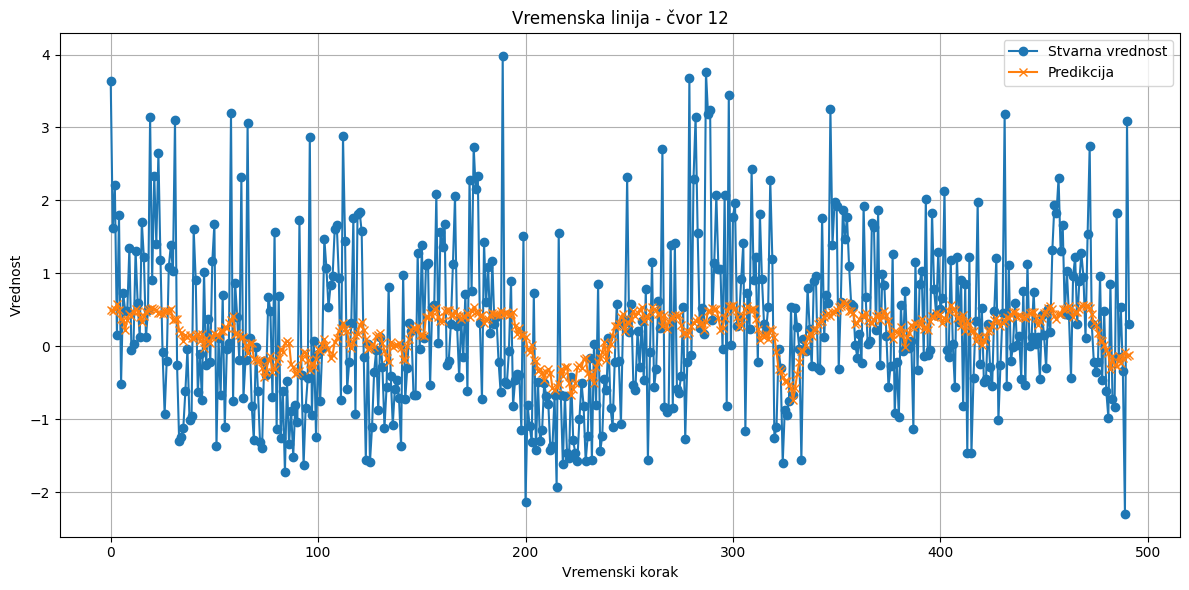

In [126]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_and_visualize(model, val_loader, device):
    model.eval()
    criterion = torch.nn.MSELoss(reduction='none')

    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_t, W_in, W_out, A, Y_t in val_loader:
            X_t = X_t.float().to(device)
            W_in = W_in.float().to(device)
            W_out = W_out.float().to(device)
            Y_t = Y_t.float().to(device)

            batch_size_current = X_t.size(0)
            num_nodes = 35
            H_t_prev = torch.zeros(batch_size_current, in_channels, num_nodes).to(device)
            y_pred, _ = model(X_t, W_in, W_out, H_t_prev)
            y_pred = y_pred.squeeze(-1)



            all_y_true.append(Y_t.cpu())
            all_y_pred.append(y_pred.cpu())

    all_y_true = torch.cat(all_y_true, dim=0).numpy()
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()

    # MSE po čvorovima
    mse_per_node = np.mean((all_y_true - all_y_pred) ** 2, axis=0)
    print("\n MSE po čvorovima:")
    for i, mse_val in enumerate(mse_per_node):
        print(f"Čvor {i:02d}: {mse_val:.4f}")

    # R² skor
    def r2_score(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

    r2 = r2_score(all_y_true.flatten(), all_y_pred.flatten())
    print(f"R² skor (svi čvorovi): {r2:.4f}")

    #  SCATTER: stvarno vs predikcija
    plt.figure(figsize=(8, 8))
    plt.scatter(all_y_true.flatten(), all_y_pred.flatten(), alpha=0.05, s=5)
    plt.plot([all_y_true.min(), all_y_true.max()],
             [all_y_true.min(), all_y_true.max()], 'r--')
    plt.xlabel("Stvarna vrednost")
    plt.ylabel("Predikcija")
    plt.title("Predikcija vs. stvarna vrednost (validacija)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #  HEATMAP: MSE po čvorovima
    plt.figure(figsize=(10, 1))
    sns.heatmap(mse_per_node[np.newaxis, :], cmap="YlOrRd", annot=True, fmt=".3f", cbar=False)
    plt.yticks([])
    plt.title("MSE po čvorovima")
    plt.xlabel("Čvor indeks")
    plt.tight_layout()
    plt.show()

    #  LINIJSKI: uporedi seriju za jedan čvor
    node_idx = 12  # promeni ako želiš drugi čvor
    true_series = all_y_true[:, node_idx]
    pred_series = all_y_pred[:, node_idx]

    plt.figure(figsize=(12, 6))
    plt.plot(true_series, label='Stvarna vrednost', marker='o')
    plt.plot(pred_series, label='Predikcija', marker='x')
    plt.title(f'Vremenska linija - čvor {node_idx}')
    plt.xlabel('Vremenski korak')
    plt.ylabel('Vrednost')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
evaluate_and_visualize(model, val_loader, device)

**TRENIRANJE SAMO SPATIAL DELA**


In [161]:
class SpatialGCN(nn.Module):
    def __init__(self, in_channels, out_channels, num_nodes):
        super(SpatialGCN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_nodes = num_nodes
        self.theta = nn.Parameter(torch.randn(num_nodes, num_nodes))
        self.Z = nn.Parameter(torch.randn(num_nodes, num_nodes))

        self.phi = nn.Conv1d(63, 63, kernel_size=1)
        self.psi = nn.Conv1d(63, 63, kernel_size=1)
        self.linear = nn.Linear(out_channels, 1)
        self.bn = nn.BatchNorm1d(35)
        self.dropout = nn.Dropout(0.3)

    def forward(self, H_last, A):
        batch_size = H_last.shape[0]
        row_sums = A.sum(dim=2)  # suma po kolonama tj dim=2 (jer A je batch x n x n)
        Q = torch.diag_embed(row_sums)  # shape: (batch_size, num_nodes, num_nodes)

        Q_inv = torch.diag_embed(1.0 / (row_sums + 1e-6))  # izbegavamo deljenje nulom
        I = torch.eye(self.num_nodes, device=H_last.device).unsqueeze(0).repeat(batch_size, 1, 1)  # batch x n x n
        #H_last = H_last.permute(0,2,1)

        phi_H = self.phi(H_last)  # (batch_size, out_channels, num_nodes)
        psi_H = self.psi(H_last)  # (batch_size, out_channels, num_nodes)
        phi_H_t = phi_H #.permute(0, 2, 1)  # batch x num_nodes x out_channels
        psi_H_t = psi_H #.permute(0, 2, 1)  # batch x num_nodes x out_channels
        H_last_transponse = H_last.transpose(1, 2)
        S_prem_1 = torch.bmm( psi_H_t, phi_H_t.transpose(1, 2))  # batch x num_nodes x num_nodes

    #     #print("1", S_prem_1.shape)
    #     #print("H_last_transponse", H_last_transponse.shape)
        S_prem_2 = torch.bmm(H_last_transponse, S_prem_1)
    #    # print("2", S_prem_2.shape)
    #    # print("H_last", H_last.shape)
        S_prem_3 = torch.bmm(S_prem_2, H_last)
    #    # print("3", S_prem_3.shape)
        S = torch.softmax(S_prem_3, dim=-1)  # softmax po poslednjoj dimenziji (po koloni)
        Z_batch = self.Z.unsqueeze(0).repeat(batch_size, 1, 1)  # batch x n x n
    #     #print("A : ", A.shape)

        # #print("S : ", S.shape)
        M = A +  Z_batch + S# batch x n x n

        temp = torch.bmm(Q_inv, M)  # batch x n x n
        left = I + temp  # batch x n x n

        H_last_t = H_last.permute(0, 2, 1)  # batch x num_nodes x in_channels
        out_t = torch.bmm(M, H_last_t)  # batch x num_nodes x in_channels

        theta_batch = self.theta.unsqueeze(0).expand(batch_size, -1, -1)  # (batch_size, num_nodes, num_nodes)

        out_t = torch.bmm(theta_batch, H_last.permute(0,2,1))  # (batch_size, num_nodes, in_channels)
        out = out_t#.permute(0, 2, 1)  # batch x in_channels x num_nodes
        out = self.linear(out)
        out = out.squeeze(-1)
        out = self.bn(out)
        out = torch.relu(out)
        out = self.dropout(out)

        return out


In [162]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

in_channels = 63
num_nodes = 35
out_channels = 63  # možeš promeniti


model = SpatialGCN(in_channels, out_channels, num_nodes).to(device)

# Loss i optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# DataLoader-i
batch_size = 64
val_split = 0.2
dataset_size = len(DataLoader_prepared)
val_size = int(val_split * dataset_size)
train_size = dataset_size - val_size

train_dataset, val_dataset = random_split(DataLoader_prepared, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Trening
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_t, W_in, W_out, A, Y_t in train_loader:
        X_t, A, Y_t = X_t.to(device), A.to(device), Y_t.to(device)
        optimizer.zero_grad()
        y_pred = model(X_t, A)
        loss = criterion(y_pred, Y_t)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validacija
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_t, W_in, W_out, A, Y_t in val_loader:
            X_t, A, Y_t = X_t.to(device), A.to(device), Y_t.to(device)
            y_pred = model(X_t, A)
            loss = criterion(y_pred, Y_t)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


Epoch [1/100] | Train Loss: 1.6577 | Val Loss: 1.4424
Epoch [2/100] | Train Loss: 1.5714 | Val Loss: 1.3501
Epoch [3/100] | Train Loss: 1.4718 | Val Loss: 1.3166
Epoch [4/100] | Train Loss: 1.3930 | Val Loss: 1.2792
Epoch [5/100] | Train Loss: 1.3366 | Val Loss: 1.2021
Epoch [6/100] | Train Loss: 1.2721 | Val Loss: 1.1729
Epoch [7/100] | Train Loss: 1.2238 | Val Loss: 1.1377
Epoch [8/100] | Train Loss: 1.1839 | Val Loss: 1.1121
Epoch [9/100] | Train Loss: 1.1536 | Val Loss: 1.0869
Epoch [10/100] | Train Loss: 1.1247 | Val Loss: 1.0654
Epoch [11/100] | Train Loss: 1.1036 | Val Loss: 1.0534
Epoch [12/100] | Train Loss: 1.0813 | Val Loss: 1.0459
Epoch [13/100] | Train Loss: 1.0617 | Val Loss: 1.0312
Epoch [14/100] | Train Loss: 1.0490 | Val Loss: 1.0174
Epoch [15/100] | Train Loss: 1.0368 | Val Loss: 1.0132
Epoch [16/100] | Train Loss: 1.0275 | Val Loss: 1.0063
Epoch [17/100] | Train Loss: 1.0185 | Val Loss: 1.0009
Epoch [18/100] | Train Loss: 1.0158 | Val Loss: 0.9964
Epoch [19/100] | Tr


MSE po čvorovima:
Node 0: 0.4713
Node 1: 0.7866
Node 2: 0.7429
Node 3: 1.1300
Node 4: 0.7891
Node 5: 0.7372
Node 6: 0.8739
Node 7: 0.6605
Node 8: 0.9165
Node 9: 0.9901
Node 10: 0.6371
Node 11: 0.9142
Node 12: 1.0781
Node 13: 2.0826
Node 14: 1.4898
Node 15: 1.0389
Node 16: 0.9835
Node 17: 0.9586
Node 18: 0.6335
Node 19: 1.0832
Node 20: 0.7415
Node 21: 0.7159
Node 22: 1.0876
Node 23: 0.7433
Node 24: 0.5743
Node 25: 0.9801
Node 26: 0.9733
Node 27: 0.6174
Node 28: 0.8389
Node 29: 0.8602
Node 30: 0.9730
Node 31: 1.0292
Node 32: 0.9380
Node 33: 0.8129
Node 34: 0.9370

R2 skor (svi čvorovi i svi uzorci): 0.0909


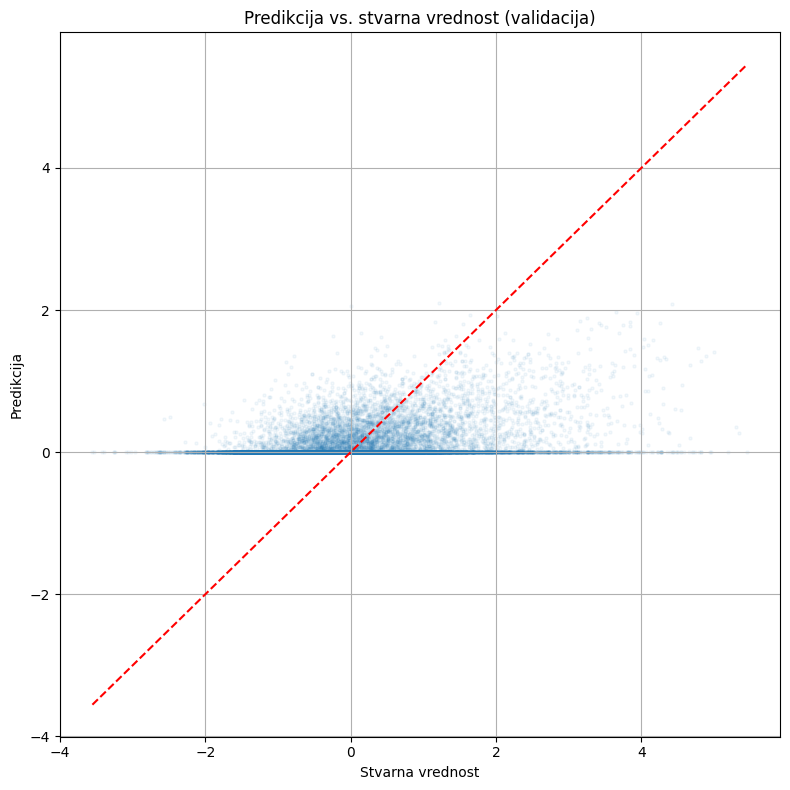

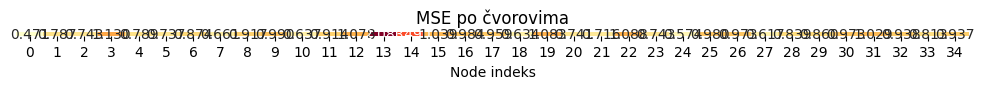

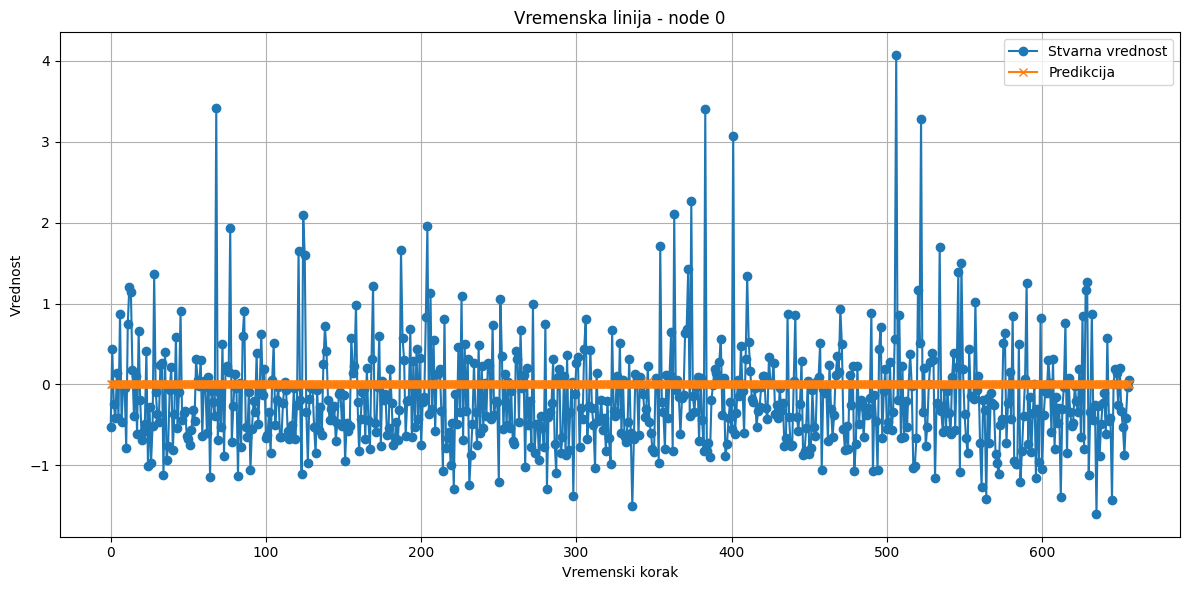

In [164]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_and_visualize(model, val_loader, device):
    model.eval()
    criterion = torch.nn.MSELoss(reduction='none')

    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_t, W_in, W_out, A, Y_t in val_loader:
            # prebaci na device i permutuj ako treba (kao kod treninga)
            X_t, A, Y_t = X_t.to(device), A.to(device), Y_t.to(device)
            y_pred = model(X_t, A)  # (batch, num_nodes) ili (batch, out_channels, num_nodes)
            if y_pred.dim() == 3:  # ako ima kanal dimenziju, stisni
                y_pred = y_pred.squeeze(1)

            if Y_t.dim() == 3:
                Y_t = Y_t.squeeze(1)

            all_y_true.append(Y_t.cpu())
            all_y_pred.append(y_pred.cpu())

    all_y_true = torch.cat(all_y_true, dim=0).numpy()  # (samples, nodes)
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()

    # MSE po node-ovima
    mse_per_node = np.mean((all_y_true - all_y_pred) ** 2, axis=0)
    print("\nMSE po čvorovima:")
    for i, mse_val in enumerate(mse_per_node):
        print(f"Node {i}: {mse_val:.4f}")

    # R2 skor funkcija
    def r2_score(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

    r2 = r2_score(all_y_true.flatten(), all_y_pred.flatten())
    print(f"\nR2 skor (svi čvorovi i svi uzorci): {r2:.4f}")

    # --- VIZUALIZACIJE ---

    # 1. Scatter plot stvarnih vrednosti vs predikcija
    plt.figure(figsize=(8, 8))
    plt.scatter(all_y_true.flatten(), all_y_pred.flatten(), alpha=0.05, s=5)
    plt.plot([all_y_true.min(), all_y_true.max()],
             [all_y_true.min(), all_y_true.max()], 'r--')
    plt.xlabel("Stvarna vrednost")
    plt.ylabel("Predikcija")
    plt.title("Predikcija vs. stvarna vrednost (validacija)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Heatmap MSE po čvorovima
    plt.figure(figsize=(10, 1))
    sns.heatmap(mse_per_node[np.newaxis, :], cmap="YlOrRd", annot=True, fmt=".3f", cbar=False)
    plt.yticks([])
    plt.title("MSE po čvorovima")
    plt.xlabel("Node indeks")
    plt.tight_layout()
    plt.show()

    # 3. Linijski graf za jedan node
    node_idx = 0  # možeš promeniti indeks čvora
    true_series = all_y_true[:, node_idx]
    pred_series = all_y_pred[:, node_idx]

    plt.figure(figsize=(12, 6))
    plt.plot(true_series, label='Stvarna vrednost', marker='o')
    plt.plot(pred_series, label='Predikcija', marker='x')
    plt.title(f'Vremenska linija - node {node_idx}')
    plt.xlabel('Vremenski korak')
    plt.ylabel('Vrednost')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Pozivanje funkcije (nakon treninga)
evaluate_and_visualize(model, val_loader, device)


# **TRENIRANJE SAMO TEMPORAL DELA**

In [166]:
def conv_init(conv):
    nn.init.kaiming_normal_(conv.weight, mode='fan_out')
    nn.init.constant_(conv.bias, 0)


def bn_init(bn, scale):
    nn.init.constant_(bn.weight, scale)
    nn.init.constant_(bn.bias, 0)


class TemporalGCN(nn.Module):
  "https://github.com/lshiwjx/2s-AGCN/blob/master/model/agcn.py"
  def __init__(self, in_channels, out_channels, kernel_size=5, stride=1):
      super(TemporalGCN, self).__init__()
      pad = int((kernel_size - 1) / 2)
      self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=(kernel_size, 1), padding=(pad, 0),
                            stride=(stride, 1))

      self.bn = nn.BatchNorm2d(out_channels)
      self.relu = nn.ReLU()
      conv_init(self.conv)
      bn_init(self.bn, 1)

  def forward(self, x):
      x = self.bn(self.conv(x))
      return x


Epoch 1/500 - Train Loss: 1.875105 - Val Loss: 1.872745
Epoch 2/500 - Train Loss: 1.721397 - Val Loss: 1.716853
Epoch 3/500 - Train Loss: 1.599942 - Val Loss: 1.570037
Epoch 4/500 - Train Loss: 1.509902 - Val Loss: 1.484061
Epoch 5/500 - Train Loss: 1.427467 - Val Loss: 1.404631
Epoch 6/500 - Train Loss: 1.351638 - Val Loss: 1.323179
Epoch 7/500 - Train Loss: 1.296789 - Val Loss: 1.284587
Epoch 8/500 - Train Loss: 1.248398 - Val Loss: 1.205565
Epoch 9/500 - Train Loss: 1.199512 - Val Loss: 1.181697
Epoch 10/500 - Train Loss: 1.159508 - Val Loss: 1.146039
Epoch 11/500 - Train Loss: 1.121435 - Val Loss: 1.104494
Epoch 12/500 - Train Loss: 1.098029 - Val Loss: 1.078570
Epoch 13/500 - Train Loss: 1.070278 - Val Loss: 1.057115
Epoch 14/500 - Train Loss: 1.040313 - Val Loss: 1.030539
Epoch 15/500 - Train Loss: 1.026709 - Val Loss: 1.017725
Epoch 16/500 - Train Loss: 1.004574 - Val Loss: 0.996590
Epoch 17/500 - Train Loss: 0.992018 - Val Loss: 0.985334
Epoch 18/500 - Train Loss: 0.977546 - Va

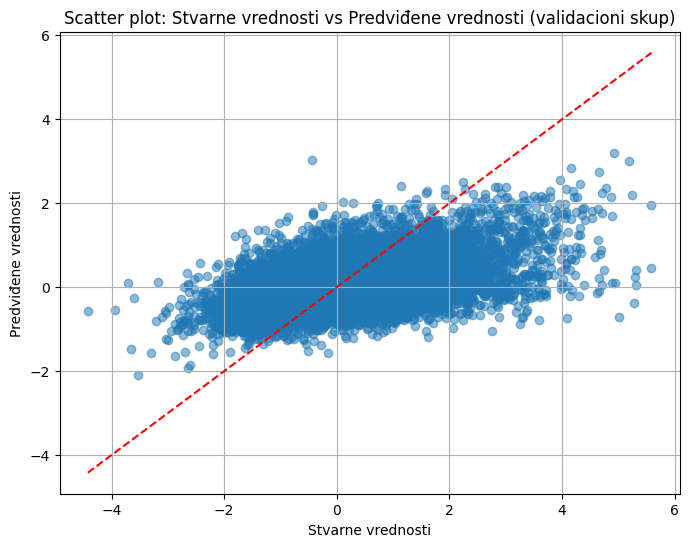

In [167]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_temporalgcn_with_val_and_plot(DataLoader_prepared, num_epochs=200, lr=0.001, batch_size=64, val_split=0.2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    dataset_size = len(DataLoader_prepared)
    val_size = int(val_split * dataset_size)
    train_size = dataset_size - val_size

    train_dataset, val_dataset = random_split(DataLoader_prepared, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    in_channels = DataLoader_prepared.X_t.shape[1]
    num_nodes = DataLoader_prepared.X_t.shape[2]
    out_channels = 1

    model = TemporalGCN(in_channels, out_channels).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for X_t, W_in, W_out, A, Y_t in train_loader:
            X_t = X_t.to(device).unsqueeze(2)  # (batch, in_channels, 1, num_nodes)
            Y_t = Y_t.to(device)

            optimizer.zero_grad()
            output = model(X_t)  # (batch, out_channels, 1, num_nodes)
            output = output.squeeze(2).squeeze(1)  # (batch, num_nodes)

            if Y_t.dim() == 3:
                Y_t = Y_t.squeeze(1)

            loss = criterion(output, Y_t)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for X_t, W_in, W_out, A, Y_t in val_loader:
                X_t = X_t.to(device).unsqueeze(2)
                Y_t = Y_t.to(device)

                output = model(X_t)
                output = output.squeeze(2).squeeze(1)

                if Y_t.dim() == 3:
                    Y_t = Y_t.squeeze(1)

                loss = criterion(output, Y_t)
                total_val_loss += loss.item()

                all_preds.append(output.cpu())
                all_targets.append(Y_t.cpu())

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.6f} - Val Loss: {avg_val_loss:.6f}")

    # Posle treninga sklopi sve predikcije i targete u jedan tensor
    all_preds = torch.cat(all_preds, dim=0).numpy().flatten()
    all_targets = torch.cat(all_targets, dim=0).numpy().flatten()

    # Scatter plot: stvarne vrednosti vs predviđanja
    plt.figure(figsize=(8, 6))
    plt.scatter(all_targets, all_preds, alpha=0.5)
    plt.xlabel("Stvarne vrednosti")
    plt.ylabel("Predviđene vrednosti")
    plt.title("Scatter plot: Stvarne vrednosti vs Predviđene vrednosti (validacioni skup)")
    plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'r--')  # linija y=x
    plt.grid(True)
    plt.show()

    return model

# Pokreni trening sa vizualizacijom
model_temporal = train_temporalgcn_with_val_and_plot(DataLoader_prepared)



MSE po čvorovima:
Node 0: 0.3631
Node 1: 0.7328
Node 2: 0.7023
Node 3: 0.8007
Node 4: 0.7746
Node 5: 0.6919
Node 6: 0.8750
Node 7: 0.6222
Node 8: 0.6073
Node 9: 0.7178
Node 10: 0.5415
Node 11: 0.7466
Node 12: 1.0654
Node 13: 1.7251
Node 14: 1.3810
Node 15: 0.7866
Node 16: 0.8001
Node 17: 0.8622
Node 18: 0.3912
Node 19: 0.8181
Node 20: 0.7143
Node 21: 0.6847
Node 22: 1.0277
Node 23: 0.5723
Node 24: 0.4291
Node 25: 0.8391
Node 26: 0.9096
Node 27: 0.5591
Node 28: 0.8202
Node 29: 0.8090
Node 30: 0.6505
Node 31: 0.8246
Node 32: 0.8265
Node 33: 0.7855
Node 34: 0.9007

R2 skor (svi čvorovi i svi uzorci): 0.2183


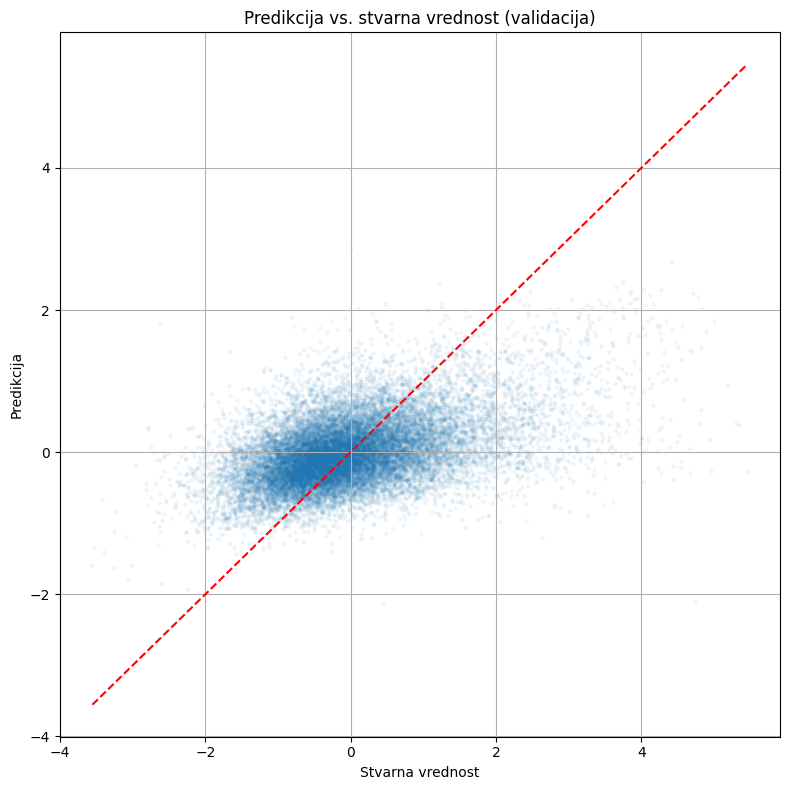

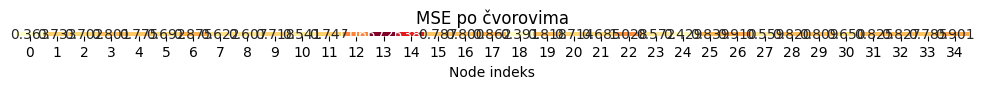

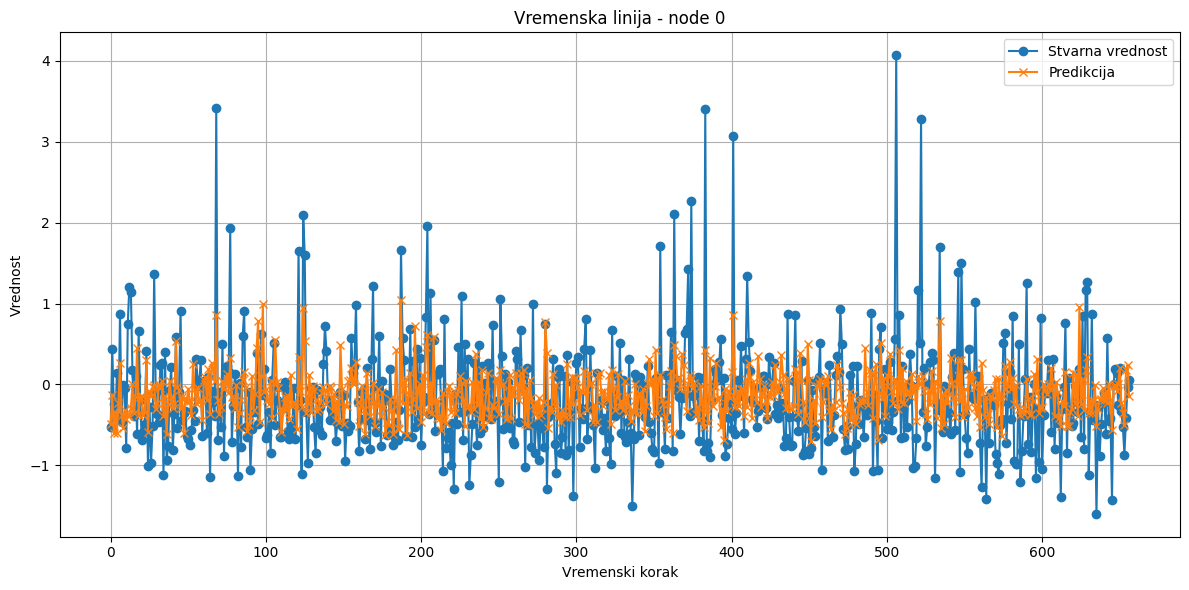

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

def evaluate_and_visualize(model, val_loader, device):
    model.eval()
    criterion = torch.nn.MSELoss(reduction='none')

    all_y_true = []
    all_y_pred = []

    with torch.no_grad():
        for X_t, W_in, W_out, A, Y_t in val_loader:
            X_t = X_t.float().to(device).unsqueeze(2)  # (batch, in_channels, 1, num_nodes)
            Y_t = Y_t.float().to(device)

            y_pred = model(X_t)  # (batch, out_channels, 1, num_nodes)
            y_pred = y_pred.squeeze(2).squeeze(1)  # (batch, num_nodes)

            if Y_t.dim() == 3:
                Y_t = Y_t.squeeze(1)  # (batch, num_nodes)

            all_y_true.append(Y_t.cpu())
            all_y_pred.append(y_pred.cpu())

    # Spoji batch-eve u celinu
    all_y_true = torch.cat(all_y_true, dim=0).numpy()  # shape: (samples, nodes)
    all_y_pred = torch.cat(all_y_pred, dim=0).numpy()

    # MSE po node-ovima
    mse_per_node = np.mean((all_y_true - all_y_pred) ** 2, axis=0)
    print("\nMSE po čvorovima:")
    for i, mse_val in enumerate(mse_per_node):
        print(f"Node {i}: {mse_val:.4f}")

    # R2 skor funkcija
    def r2_score(y_true, y_pred):
        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        return 1 - (ss_res / ss_tot)

    r2 = r2_score(all_y_true.flatten(), all_y_pred.flatten())
    print(f"\nR2 skor (svi čvorovi i svi uzorci): {r2:.4f}")

    # --- VIZUALIZACIJE ---

    # 1. Scatter plot stvarnih vrednosti vs predikcija
    plt.figure(figsize=(8, 8))
    plt.scatter(all_y_true.flatten(), all_y_pred.flatten(), alpha=0.05, s=5)
    plt.plot([all_y_true.min(), all_y_true.max()],
             [all_y_true.min(), all_y_true.max()], 'r--')
    plt.xlabel("Stvarna vrednost")
    plt.ylabel("Predikcija")
    plt.title("Predikcija vs. stvarna vrednost (validacija)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 2. Heatmap MSE po čvorovima
    plt.figure(figsize=(10, 1))
    sns.heatmap(mse_per_node[np.newaxis, :], cmap="YlOrRd", annot=True, fmt=".3f", cbar=False)
    plt.yticks([])
    plt.title("MSE po čvorovima")
    plt.xlabel("Node indeks")
    plt.tight_layout()
    plt.show()

    # 3. Linijski graf za jedan node
    node_idx = 0  # promeni indeks ako želiš drugi node
    true_series = all_y_true[:, node_idx]
    pred_series = all_y_pred[:, node_idx]

    plt.figure(figsize=(12, 6))
    plt.plot(true_series, label='Stvarna vrednost', marker='o')
    plt.plot(pred_series, label='Predikcija', marker='x')
    plt.title(f'Vremenska linija - node {node_idx}')
    plt.xlabel('Vremenski korak')
    plt.ylabel('Vrednost')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Primer korišćenja:
# Pretpostavljam da si već podelio dataset i da imaš val_loader, kao u funkciji treninga.
# npr:
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
# i model je već istreniran

evaluate_and_visualize(model_temporal, val_loader, device)


# **ZAKLJUCAK**

Iz gore prikazanog vidimo da model dobro hvata vremenske zavisnosti izmedju letova. Medjutim kod inplementiranog modela, model lose predvidja spatijalni deo. U daljem radu planiram da popravim spatijalni deo koji ce konacnoj predikciji dati bolje rezultate.